In [1]:
import numpy as np
import networkx as nx
from dotmotif import Motif, GrandIsoExecutor
import matplotlib.pyplot as plt
from scipy.stats import ranksums
from lsmm_data import LSMMData
import json
from tqdm import tqdm
import scipy.stats as stats
import pandas as pd
# from collections import defaultdict
import pickle

with open('v1dd_data_structures_information.json') as f:
    loaded_json = json.load(f)
my_data = LSMMData.LSMMData(loaded_json)

c:\Users\saika\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
c:\Users\saika\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\saika\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Generating Connectome...


100%|██████████| 137706/137706 [02:45<00:00, 833.15it/s] 


Generating Connectome...


100%|██████████| 137706/137706 [03:07<00:00, 733.60it/s]


In [86]:
pip install update lsmm_data-0.1.2-py2.py3-none-any.whl

Processing c:\users\saika\downloads\assembly_paper\lsmm_data-0.1.2-py2.py3-none-any.whl
  Attempting uninstall: lsmm-data
    Found existing installation: lsmm_data 0.1.6
    Uninstalling lsmm_data-0.1.6:
      Successfully uninstalled lsmm_data-0.1.6
Note: you may need to restart the kernel to use updated packages.


In [88]:
pip show lsmm_data

Name: lsmm_dataNote: you may need to restart the kernel to use updated packages.

Version: 0.1.2
Summary: 
Home-page: 
Author: 
Author-email: 
License: 
Location: c:\users\saika\anaconda3\lib\site-packages
Requires: 
Required-by: 


In [2]:
data_a = my_data.data
params_a = my_data.params
dirs_a = my_data.dirs
mappings_a = my_data.mappings

In [3]:
# Make a graph
cell_table = data_a['structural']['pre_cell'].copy()
cell_table['connectome_index'] = cell_table.index
post_cell_table = data_a['structural']['post_cell'].copy()
post_cell_table['connectome_index'] = post_cell_table.index

synapse_table = data_a['structural']['synapse']
# adjacency_matrix = data_a['structural']['binary_connectome']

binary_connectome = data_a['structural']['binary_connectome']
summed_size_connectome = data_a['structural']['summed_size_connectome']

pyr_graph = nx.from_numpy_array(binary_connectome, create_using=nx.DiGraph)
import pickle

with open('cell_table.pkl', 'wb') as f:
    pickle.dump(cell_table, f)

with open('post_cell_table.pkl', 'wb') as f:
    pickle.dump(post_cell_table, f)

with open('synapse_table.pkl', 'wb') as f:
    pickle.dump(synapse_table, f)

# # Add edges to the graph
# rows, cols = data_a['structural']['binary_connectome'].shape
# for i in range(rows):
#     for j in range(cols):
#         if data_a['structural']['binary_connectome'][i, j] != 0:  # 0 means no edge
#             pyr_graph.add_edge(f'pre_{i}', f'post_{j}', weight=data_a['structural']['binary_connectome'][i, j])

## Uncomment below to load existing chain motif analysis results
# two_chain_results_array = np.load('all_cell_two_chain_results_array.npy')
# three_chain_results_array = np.load('all_cell_three_chain_results_array.npy')
# four_chain_results_array = np.load('all_cell_four_chain_results_array.npy')

# Or uncomment below to generate new motif analysis results (Can take quite a while on larger graphs)
# Motif Analysis with DotMotif: 2 Chain, All Pyr
executor = GrandIsoExecutor(graph=pyr_graph)
chain_defs = Motif("""
                A -> B
                B -> C
              """)

chain_results = executor.find(chain_defs)

# Filter the chain results for chains from an excitatory cell to an inhibitory cell to an excitatory cell
# filtered_chain_results = []
# for chain in chain_results:
#     if cell_table.iloc[chain['A'].split('_')[1]]. and cell_table.iloc[chain['A'].split('_')[1]] chain['C'].split('_')[0] == 'post':
#         filtered_chain_results.append(chain)


two_chain_results_array = np.array([list(c.values()) for c in tqdm(chain_results)])
# removed_pre_post_strings = np.zeros_like(two_chain_results_array)
# for i, c in enumerate(chain_results):
#     for j, n in enumerate(c.values()):
#         removed_pre_post_strings[i, j] = int(n.split('_')[1])

#two_chain_results_array = np.array(removed_pre_post_strings).astype(int)

# two_chain_results_array = np.array([list(c.values()) for c in tqdm(chain_results)])

#assembly_chain_results_arrays = [two_chain_results_array]

chain_count_string_array = ['pyr_cell_2chain']
individual_assembly_indexes = [mappings_a['connectome_indexes_by_assembly'][f'A {i}'] for i in range(1,16)]
individual_post_assembly_indexes = [mappings_a['post_connectome_indexes_by_assembly'][f'A {i}'] for i in range(1,16)]

coregistered_post_cell_indexes = mappings_a['assemblies_by_post_connectome_index'].keys()
coregistered_cell_indexes = mappings_a['assemblies_by_connectome_index'].keys()
no_a_cell_indexes = mappings_a['connectome_indexes_by_assembly']['No A']
no_a_post_cell_indexes = mappings_a['post_connectome_indexes_by_assembly']['No A']
pooled_assembly_indexes = list(set(coregistered_cell_indexes) - set(no_a_cell_indexes))
pooled_assembly_post_indexes = list(set(coregistered_post_cell_indexes) - set(no_a_post_cell_indexes))

assembly_to_root_ids = mappings_a['pt_root_ids_by_assembly']
assembly_root_ids_set = set(mappings_a['assemblies_by_pt_root_id'].keys())

# Filter synapses_table to only synapses between two assembly cells (including No A)
synapses_df = synapse_table[synapse_table['pre_pt_root_id'].isin(assembly_root_ids_set)]   #gets assembly cells based on pre-pt-root-id
synapses_df = synapses_df[synapses_df['post_pt_root_id'].isin(assembly_root_ids_set)]    #takes the dict with pre assembly cells and further filters for post pt-root-id 

# Filter cell tables to only assembly cells
assembly_cell_table = cell_table[cell_table['pt_root_id'].isin(assembly_root_ids_set)]
assembly_post_cell_table = post_cell_table[post_cell_table['pt_root_id'].isin(assembly_root_ids_set)]

assembly_pre_root_ids = set(assembly_cell_table['pt_root_id'].values)
assembly_post_root_ids = set(assembly_post_cell_table['pt_root_id'].values)
assembly_all_root_ids = assembly_pre_root_ids | assembly_post_root_ids


100%|██████████| 6052393/6052393 [00:08<00:00, 733216.73it/s] 


In [4]:
x = synapse_table[synapse_table['pre_pt_root_id'].isin(assembly_root_ids_set)]
x

,id,pre_pt_root_id,post_pt_root_id,pt_position_x,pt_position_y,pt_position_z,size,pt_position_x_trafo,pt_position_y_trafo,pt_position_z_trafo,ctr_pt_position
15,385871060,864691132748334211,864691132713081093,803072.7,650714.8,237465.0,1147,-85117.255514,306869.009066,-47134.439571,"[-85117.25551443589, 306869.0090664734, -47134..."
22,400682910,864691132841768198,864691132713081093,805041.8,712988.8,297090.0,1300,-97751.777724,384323.506911,-6662.605649,"[-97751.77772377743, 384323.5069107702, -6662...."
47,354037317,864691132712062021,864691132713081093,752778.2,656806.4,257040.0,911,-137085.302904,318360.625595,-29681.003831,"[-137085.30290407952, 318360.6255949742, -2968..."
51,378751644,864691132734110999,864691132713081093,798513.7,667796.5,248580.0,1574,-92622.696310,326565.622821,-40602.965744,"[-92622.69631006179, 326565.622821283, -40602...."
63,468573544,864691132678493470,864691132937982091,913342.3,728004.4,305865.0,815,6705.538694,401075.747886,-2701.409404,"[6705.53869431683, 401075.74788560363, -2701.4..."
...,...,...,...,...,...,...,...,...,...,...,...
137519,391293053,864691132921491681,864691132655536611,819756.7,632711.6,170910.0,1164,-63588.495897,271251.262965,-107688.956019,"[-63588.49589710794, 271251.2629645617, -10768..."
137545,423870350,864691132921491681,864691132688960776,860797.4,727364.2,223425.0,1875,-40521.812155,378005.434125,-81267.273699,"[-40521.812154830746, 378005.434125318, -81267..."
137547,377128104,864691132747994573,864691132689099528,802587.7,727529.1,265095.0,3963,-101461.016171,389937.531399,-41561.201626,"[-101461.01617127818, 389937.5313992617, -4156..."
137634,373066345,864691132921491681,864691132655931504,766096.3,717499.3,262665.0,308,-135591.979384,379517.190261,-40926.478717,"[-135591.97938415446, 379517.19026121864, -409..."


In [5]:
mappings_a.keys()

dict_keys(['functional_indexes_by_assembly', 'assemblies_by_functional_index', 'pt_root_id_to_connectome_index', 'connectome_index_to_root_id', 'pt_root_id_to_post_connectome_index', 'post_connectome_index_to_root_id', 'roi_id_to_pt_root_id', 'pt_root_id_to_roi_id', 'roi_id_to_functional_index', 'functional_index_to_roi_id', 'assemblies_by_roi_id', 'assemblies_by_pt_root_id', 'assemblies_by_connectome_index', 'assemblies_by_post_connectome_index', 'connectome_indexes_by_assembly', 'post_connectome_indexes_by_assembly', 'pt_root_ids_by_assembly', 'roi_ids_by_assembly'])

### TESTS IN THE DOCUMENT:
1. Signed ranksum for non-zero summed PSD
2. Ranksums for non-zero summed PSD
3. Signed ranksums for probability of connections
4. Un-signed ranksums for probability of connections
5. Chi-square analysis for binary connections
6. Levene and t-test on log10 data

### Alternate logic for comparison with Julian's code - Normalization by total chain length

In [6]:
inhibitory_cells =cell_table[cell_table['classification_system'] == 'inhibitory']
inhibitory_cells_root_ids_set = set(inhibitory_cells['pt_root_id'].values)

synapses_df_pre_assembly = synapse_table[synapse_table['pre_pt_root_id'].isin(assembly_root_ids_set)]   #gets assembly cells based on pre-pt-root-id
synapses_df_inhibitory_pre = synapse_table[synapse_table['pre_pt_root_id'].isin(inhibitory_cells_root_ids_set)]

synapses_df_pre_assembly_to_inhibitory = synapses_df_pre_assembly[synapses_df_pre_assembly['post_pt_root_id'].isin(inhibitory_cells_root_ids_set)]

synapses_df_inhibitory_post = synapse_table[synapse_table['post_pt_root_id'].isin(inhibitory_cells_root_ids_set)]
synapses_df_post_assembly = synapse_table[synapse_table['post_pt_root_id'].isin(assembly_root_ids_set)]

synapses_df_inhibitory_to_post_assembly = synapses_df_post_assembly[synapses_df_post_assembly['pre_pt_root_id'].isin(inhibitory_cells_root_ids_set)]

excitatory_cells =cell_table[cell_table['classification_system'] == 'excitatory']
excitatory_cells_root_ids_set = set(excitatory_cells['pt_root_id'].values)

synapses_df_pre_assembly_to_excitatory = synapses_df_pre_assembly[synapses_df_pre_assembly['post_pt_root_id'].isin(excitatory_cells_root_ids_set)]
synapses_df_excitatory_to_post_assembly = synapses_df_post_assembly[synapses_df_post_assembly['pre_pt_root_id'].isin(excitatory_cells_root_ids_set)]

# Prep the sets


#W_ikj - j: pre-cell, k: middle cell, i: post-cell

# Collect w and s for inhibitory - k is inhibitory cell
# corresponds to w_kj in formula (1)
w_jk = {}   #PSD
s_jk = {}   #Synaptic count 
b_jk = {}   #Binary count  or connectivity - either 1 or 0

# corresponds to w_ik in formula (1)
w_ki = {}   #PSD
s_ki = {}   #Synaptic count 
b_ki = {}   #Binary count  or connectivity - either 1 or 0

# Collect w and s for excitatory - k is excitatory cell
w_jkE = {}   #PSD
s_jkE = {}   #Synaptic count 
b_jkE = {}   #Binary count  or connectivity - either 1 or 0

w_kiE = {}   #PSD
s_kiE = {}   #Synaptic count 
b_kiE = {}   #Binary count  or connectivity - either 1 or 0


for pre in assembly_pre_root_ids:
    for middle in inhibitory_cells_root_ids_set:
        w_jk[(pre, middle)] = 0
        s_jk[(pre, middle)] = 0
        b_jk[(pre, middle)] = 0


for middle in inhibitory_cells_root_ids_set:
    for post in assembly_post_root_ids:
        w_ki[(middle, post)] = 0
        s_ki[(middle, post)] = 0
        b_ki[(middle, post)] = 0

# get the PSD from pre-cell j to middle cell k 
for i, row in synapses_df_pre_assembly_to_inhibitory.iterrows():   #check how df.iterrows looks
    pre = row['pre_pt_root_id']
    middle = row['post_pt_root_id']
    w_jk[(pre, middle)] += row['size']
    s_jk[(pre, middle)] += 1
    b_jk[(pre, middle)] = 1

# get the PSD from middle cell k to post-cell i
for i, row in synapses_df_inhibitory_to_post_assembly.iterrows():   #check how df.iterrows looks
    middle = row['pre_pt_root_id']
    post = row['post_pt_root_id']
    w_ki[(middle, post)] += row['size']
    s_ki[(middle, post)] += 1
    b_ki[(middle, post)] = 1

# repeat the same for excitatory middle cell
for pre in assembly_pre_root_ids:
    for middle in excitatory_cells_root_ids_set:
        w_jkE[(pre, middle)] = 0
        s_jkE[(pre, middle)] = 0
        b_jkE[(pre, middle)] = 0

for middle in excitatory_cells_root_ids_set:
    for post in assembly_post_root_ids:
        w_kiE[(middle, post)] = 0
        s_kiE[(middle, post)] = 0
        b_kiE[(middle, post)] = 0

for i, row in synapses_df_pre_assembly_to_excitatory.iterrows():   #check how df.iterrows looks
    pre = row['pre_pt_root_id']
    middle = row['post_pt_root_id']
    w_jkE[(pre, middle)] += row['size']
    s_jkE[(pre, middle)] += 1
    b_jkE[(pre, middle)] = 1


for i, row in synapses_df_excitatory_to_post_assembly.iterrows():   #check how df.iterrows looks
    middle = row['pre_pt_root_id']
    post = row['post_pt_root_id']
    w_kiE[(middle, post)] += row['size']
    s_kiE[(middle, post)] += 1
    b_kiE[(middle, post)] = 1

# Split out assemblies and no_a
assembly_names = set(assembly_to_root_ids.keys()) - set(['No A'])
A_invert = {assembly: set(assembly_to_root_ids[assembly]) for assembly in assembly_names}
no_A = set(assembly_to_root_ids['No A'])
all_coregistered_root_ids = mappings_a['assemblies_by_pt_root_id'].keys()
assembly_root_ids_excluding_no_A = set(all_coregistered_root_ids) - no_A
A = {pt_root_id: set(mappings_a['assemblies_by_pt_root_id'][pt_root_id]) for pt_root_id in assembly_all_root_ids if 'No A' not in mappings_a['assemblies_by_pt_root_id'][pt_root_id]}

# C functions - for getting the different test conditions
def shared(pre, post, A):
    try:
        return not A[pre].isdisjoint(A[post])
    except KeyError:
        return False

def disjoint(pre, post, A):
    try:
        return A[pre].isdisjoint(A[post])
    except KeyError:
        return False

def shared_no_a(pre, post, A):
    return (pre in no_A) and (post in no_A)
    
def no_a_a(pre, post, A):
    return (pre in no_A) and (post not in no_A)

def a_no_a(pre, post, A):
    return (pre not in no_A) and (post in no_A)

C = [shared, disjoint, shared_no_a, no_a_a, a_no_a]

In [7]:

W_excitatory = {}      #set of all assembly pairs that have realized excitaory connections (from k to i)  - else val = 0
W_inhibitory = {}      #set of all assembly pairs that have realized inhibitory connections (from k to i)  - else val = 0
B_inhibitory = {}
B_excitatory = {}
for j in assembly_pre_root_ids:
        for i in assembly_post_root_ids:
            if i != j:
               W_excitatory[(j, i)] = 0
               W_inhibitory[(j, i)] = 0
               B_inhibitory[(j, i)] = 0
               B_excitatory[(j, i)] = 0


**Julian's logic for normalization**

**Outbound connectivity**

In [8]:



classification_map = cell_table.set_index('connectome_index')['classification_system'].to_dict() # Map to tell us if its Excitatory or Inhibitory 


# Calculate the weighted summed values

backup_assembly_pre_root_ids = assembly_pre_root_ids
backup_assembly_post_root_ids = assembly_post_root_ids




W_out_feed_forward_inhibition_chains = {c.__name__: {} for c in C}
W_out_excitatory_chains = {c.__name__: {} for c in C}


for cond_function in C:
    for j in assembly_pre_root_ids:
        # Exclude the current pre-synaptic cell from the post-synaptic candidate set
        normalizing_factor = 0
        post_root_ids = backup_assembly_post_root_ids - set([j])
        for i in post_root_ids:
            # Check if pre-synaptic cell 'j' satisfies the condition with post-synaptic cell 'i'
            if cond_function(j, i, A) and j != i:
                pre_idx = mappings_a['pt_root_id_to_connectome_index'][j]
                post_idx = mappings_a['pt_root_id_to_connectome_index'][i]

                # Filter chains where cell A in chain matches pre_idx and cell C matches post_idx
                temporary_chain_results = two_chain_results_array[(two_chain_results_array[:, 0] == pre_idx) & (two_chain_results_array[:, 2] == post_idx)]

                # Add to the normalizing factor the number of realized chains between pre_cell (position A in chain) and post cell (position C in chain)
                normalizing_factor += len(temporary_chain_results)

                # Continue if no matches are found
                if len(temporary_chain_results) == 0:
                    continue

                for chain in temporary_chain_results:  # Summing over possible intermediate nodes (k's)
                    cell_a, cell_b, cell_c = chain

                    # Classification of the intermediate node (cell B)
                    if classification_map[cell_b] == 'inhibitory':
                        k = mappings_a['connectome_index_to_root_id'][cell_b]
                        W_out_feed_forward_inhibition_chains[cond_function.__name__][j] = (W_out_feed_forward_inhibition_chains[cond_function.__name__].get(j, 0) +
                        (w_jk[(j, k)]* w_ki[(k,i)]) )
                        W_inhibitory[(j,i)] = W_out_feed_forward_inhibition_chains[cond_function.__name__][j]

                    elif classification_map[cell_b] == 'excitatory':
                        k = mappings_a['connectome_index_to_root_id'][cell_b]
                        W_out_excitatory_chains[cond_function.__name__][j] = (
                            W_out_excitatory_chains[cond_function.__name__].get(j, 0) +
                            (w_jkE[(j,k)]*w_kiE[(k,i)])
                        )
                        W_excitatory[(j,i)] = W_out_excitatory_chains[cond_function.__name__][j]
                        
        if j in W_out_feed_forward_inhibition_chains[cond_function.__name__]:
           W_out_feed_forward_inhibition_chains[cond_function.__name__][j] /= normalizing_factor

        if j in W_out_excitatory_chains[cond_function.__name__]:
            W_out_excitatory_chains[cond_function.__name__][j] /= normalizing_factor

                    

In [9]:
# Outbound Summed PSDs

print('\n\nSUMMED OUTBOUND PSDS for Feed-Forward Inhibitory CHAINS')
for c1 in C:
    for c2 in C:
        if c1.__name__ != c2.__name__:
            print(f'\n{c1.__name__} vs {c2.__name__}')
            result = stats.ranksums(list(W_out_feed_forward_inhibition_chains[c1.__name__].values()), list(W_out_feed_forward_inhibition_chains[c2.__name__].values()), alternative='greater')

            print('Greater:')
            print(result)
            if result.pvalue < 0.05:
                plt.figure()
                plt.boxplot([list(W_out_feed_forward_inhibition_chains[c1.__name__].values()), list(W_out_feed_forward_inhibition_chains[c2.__name__].values())])
                plt.title(f'OUTBOUND SUMMED PSDS: {c1.__name__} vs {c2.__name__}')



SUMMED OUTBOUND PSDS for Feed-Forward Inhibitory CHAINS

shared vs disjoint
Greater:
RanksumsResult(statistic=-0.5324415876345198, pvalue=0.702789905971789)

shared vs shared_no_a
Greater:
RanksumsResult(statistic=-0.14876789971477894, pvalue=0.5591316094807647)

shared vs no_a_a
Greater:
RanksumsResult(statistic=-0.27628324232744655, pvalue=0.6088347370593239)

shared vs a_no_a
Greater:
RanksumsResult(statistic=-0.05816588772477947, pvalue=0.523191753824342)

disjoint vs shared
Greater:
RanksumsResult(statistic=0.5324415876345198, pvalue=0.297210094028211)

disjoint vs shared_no_a
Greater:
RanksumsResult(statistic=0.22416326513328616, pvalue=0.4113151331526233)

disjoint vs no_a_a
Greater:
RanksumsResult(statistic=0.08151391459392224, pvalue=0.4675166297287648)

disjoint vs a_no_a
Greater:
RanksumsResult(statistic=0.5311750371111018, pvalue=0.2976487448662677)

shared_no_a vs shared
Greater:
RanksumsResult(statistic=0.14876789971477894, pvalue=0.44086839051923526)

shared_no_a vs di

In [10]:
# Outbound Summed PSDs

print('\n\nSUMMED OUTBOUND PSDS for Excitatory CHAINS')
for c1 in C:
    for c2 in C:
        if c1.__name__ != c2.__name__:
            print(f'\n{c1.__name__} vs {c2.__name__}')
            result = stats.ranksums(list(W_out_excitatory_chains[c1.__name__].values()), list(W_out_excitatory_chains[c2.__name__].values()), alternative='greater')
            print('Greater:')
            print(result)
            if result.pvalue < 0.05:
                plt.figure()
                plt.boxplot([list(W_out_excitatory_chains[c1.__name__].values()), list(W_out_excitatory_chains[c2.__name__].values())])
                plt.title(f'OUTBOUND SUMMED PSDS: {c1.__name__} vs {c2.__name__}')



SUMMED OUTBOUND PSDS for Excitatory CHAINS

shared vs disjoint
Greater:
RanksumsResult(statistic=1.097293968840645, pvalue=0.13625645326064317)

shared vs shared_no_a
Greater:
RanksumsResult(statistic=0.7566444492037343, pvalue=0.22463145196248752)

shared vs no_a_a
Greater:
RanksumsResult(statistic=0.2566635011696727, pvalue=0.39871927483755554)

shared vs a_no_a
Greater:
RanksumsResult(statistic=-0.2372526162433467, pvalue=0.5937695902756877)

disjoint vs shared
Greater:
RanksumsResult(statistic=-1.097293968840645, pvalue=0.8637435467393568)

disjoint vs shared_no_a
Greater:
RanksumsResult(statistic=-0.13832083379312204, pvalue=0.5550065696062781)

disjoint vs no_a_a
Greater:
RanksumsResult(statistic=-0.4126536306249159, pvalue=0.660069798859094)

disjoint vs a_no_a
Greater:
RanksumsResult(statistic=-1.208131743471013, pvalue=0.8865017043252169)

shared_no_a vs shared
Greater:
RanksumsResult(statistic=-0.7566444492037343, pvalue=0.7753685480375125)

shared_no_a vs disjoint
Greater:

**Inbound connectivity**

In [11]:
classification_map = cell_table.set_index('connectome_index')['classification_system'].to_dict() # Map to tell us if its Excitatory or Inhibitory 


# Calculate the weighted summed values

backup_assembly_pre_root_ids = assembly_pre_root_ids
backup_assembly_post_root_ids = assembly_post_root_ids




W_in_feed_forward_inhibition_chains = {c.__name__: {} for c in C}
W_in_excitatory_chains = {c.__name__: {} for c in C}


for cond_function in C:
    for i in assembly_post_root_ids:
        # Exclude the current pre-synaptic cell from the post-synaptic candidate set
        normalizing_factor = 0
        pre_root_ids = backup_assembly_pre_root_ids - set([i])
        for j in pre_root_ids:
            # Check if pre-synaptic cell 'j' satisfies the condition with post-synaptic cell 'i'
            if cond_function(j, i, A) and j != i:
                pre_idx = mappings_a['pt_root_id_to_connectome_index'][j]
                post_idx = mappings_a['pt_root_id_to_connectome_index'][i]

                # Filter chains where cell A in chain matches pre_idx and cell C matches post_idx
                temporary_chain_results = two_chain_results_array[(two_chain_results_array[:, 0] == pre_idx) & (two_chain_results_array[:, 2] == post_idx)]

                # Add to the normalizing factor the number of realized chains between pre_cell (position A in chain) and post cell (position C in chain)
                normalizing_factor += len(temporary_chain_results)

                # Continue if no matches are found
                if len(temporary_chain_results) == 0:
                    continue

                for chain in temporary_chain_results:  # Summing over possible intermediate nodes (k's)
                    cell_a, cell_b, cell_c = chain

                    # Classification of the intermediate node (cell B)
                    if classification_map[cell_b] == 'inhibitory':
                        k = mappings_a['connectome_index_to_root_id'][cell_b]
                        W_in_feed_forward_inhibition_chains[cond_function.__name__][i] = (W_in_feed_forward_inhibition_chains[cond_function.__name__].get(i, 0) +
                        (w_jk[(j, k)]* w_ki[(k,i)]) )

                    elif classification_map[cell_b] == 'excitatory':
                        k = mappings_a['connectome_index_to_root_id'][cell_b]
                        W_in_excitatory_chains[cond_function.__name__][i] = (
                            W_in_excitatory_chains[cond_function.__name__].get(i, 0) +
                            (w_jkE[(j,k)]*w_kiE[(k,i)])
                        )
                        
        if i in W_in_feed_forward_inhibition_chains[cond_function.__name__]:
           W_in_feed_forward_inhibition_chains[cond_function.__name__][i] /= normalizing_factor

        if i in W_in_excitatory_chains[cond_function.__name__]:
            W_in_excitatory_chains[cond_function.__name__][i] /= normalizing_factor


In [12]:
# Inbound Summed PSDs

print('\n\nSUMMED INBOUND PSDS for Feed-Forward Inhibitory CHAINS')
for c1 in C:
    for c2 in C:
        if c1.__name__ != c2.__name__:
            print(f'\n{c1.__name__} vs {c2.__name__}')
            result = stats.ranksums(list(W_in_feed_forward_inhibition_chains[c1.__name__].values()), list(W_in_feed_forward_inhibition_chains[c2.__name__].values()), alternative='greater')

            print('Greater:')
            print(result)
            if result.pvalue < 0.05:
                plt.figure()
                plt.boxplot([list(W_in_feed_forward_inhibition_chains[c1.__name__].values()), list(W_in_feed_forward_inhibition_chains[c2.__name__].values())])
                plt.title(f'OUTBOUND SUMMED PSDS: {c1.__name__} vs {c2.__name__}')



SUMMED INBOUND PSDS for Feed-Forward Inhibitory CHAINS

shared vs disjoint
Greater:
RanksumsResult(statistic=-0.5324415876345198, pvalue=0.702789905971789)

shared vs shared_no_a
Greater:
RanksumsResult(statistic=-0.14876789971477894, pvalue=0.5591316094807647)

shared vs no_a_a
Greater:
RanksumsResult(statistic=0.2908294386238974, pvalue=0.38559088463322694)

shared vs a_no_a
Greater:
RanksumsResult(statistic=-0.38254602783800296, pvalue=0.6489718025365293)

disjoint vs shared
Greater:
RanksumsResult(statistic=0.5324415876345198, pvalue=0.297210094028211)

disjoint vs shared_no_a
Greater:
RanksumsResult(statistic=0.3056771797272084, pvalue=0.37992522504711745)

disjoint vs no_a_a
Greater:
RanksumsResult(statistic=0.8248327812050443, pvalue=0.20473326644441436)

disjoint vs a_no_a
Greater:
RanksumsResult(statistic=-0.14264935053936392, pvalue=0.5567164400461241)

shared_no_a vs shared
Greater:
RanksumsResult(statistic=0.14876789971477894, pvalue=0.44086839051923526)

shared_no_a vs d

In [13]:
# Inbound Summed PSDs

print('\n\nSUMMED INBOUND PSDS for Excitatory CHAINS')
for c1 in C:
    for c2 in C:
        if c1.__name__ != c2.__name__:
            print(f'\n{c1.__name__} vs {c2.__name__}')
            result = stats.ranksums(list(W_in_excitatory_chains[c1.__name__].values()), list(W_in_excitatory_chains[c2.__name__].values()), alternative='greater')
            print('Greater:')
            print(result)
            if result.pvalue < 0.05:
                plt.figure()
                plt.boxplot([list(W_in_excitatory_chains[c1.__name__].values()), list(W_in_excitatory_chains[c2.__name__].values())])
                plt.title(f'OUTBOUND SUMMED PSDS: {c1.__name__} vs {c2.__name__}')



SUMMED INBOUND PSDS for Excitatory CHAINS

shared vs disjoint
Greater:
RanksumsResult(statistic=0.19086050424303608, pvalue=0.42431744216601935)

shared vs shared_no_a
Greater:
RanksumsResult(statistic=0.09413875735476426, pvalue=0.46249946657689583)

shared vs no_a_a
Greater:
RanksumsResult(statistic=0.3180418855547094, pvalue=0.3752265825245682)

shared vs a_no_a
Greater:
RanksumsResult(statistic=-0.38620062674037703, pvalue=0.6503259551929315)

disjoint vs shared
Greater:
RanksumsResult(statistic=-0.19086050424303608, pvalue=0.5756825578339806)

disjoint vs shared_no_a
Greater:
RanksumsResult(statistic=0.11230588859277421, pvalue=0.45529043646095624)

disjoint vs no_a_a
Greater:
RanksumsResult(statistic=0.3811319673727111, pvalue=0.3515526639307205)

disjoint vs a_no_a
Greater:
RanksumsResult(statistic=-0.42927285527410686, pvalue=0.6661376656507051)

shared_no_a vs shared
Greater:
RanksumsResult(statistic=-0.09413875735476426, pvalue=0.5375005334231042)

shared_no_a vs disjoint
G

## Revised logic with normalization based on excitatory and inhibitory cells

In [13]:

classification_map = cell_table.set_index('connectome_index')['classification_system'].to_dict() # Map to tell us if its Excitatory or Inhibitory 


# Calculate the weighted summed values

backup_assembly_pre_root_ids = assembly_pre_root_ids
backup_assembly_post_root_ids = assembly_post_root_ids




W_out_feed_forward_inhibition_chains = {c.__name__: {} for c in C}
W_out_excitatory_chains = {c.__name__: {} for c in C}



for cond_function in C:
    for j in assembly_pre_root_ids:
        # Exclude the current pre-synaptic cell from the post-synaptic candidate set
        normalizing_factor = 0
        normalizing_factor_excitatory_middle_cell = 0
        normalizing_factor_inhibitory_middle_cell = 0
        post_root_ids = backup_assembly_post_root_ids - set([j])
        for i in post_root_ids:
            # Check if pre-synaptic cell 'j' satisfies the condition with post-synaptic cell 'i'
            if cond_function(j, i, A) and j != i:
                pre_idx = mappings_a['pt_root_id_to_connectome_index'][j]
                post_idx = mappings_a['pt_root_id_to_connectome_index'][i]

                # Filter chains where cell A in chain matches pre_idx and cell C matches post_idx
                temporary_chain_results = two_chain_results_array[(two_chain_results_array[:, 0] == pre_idx) & (two_chain_results_array[:, 2] == post_idx)]

                # Add to the normalizing factor the number of realized chains between pre_cell (position A in chain) and post cell (position C in chain)
                normalizing_factor += len(temporary_chain_results)

                # Continue if no matches are found
                if len(temporary_chain_results) == 0:
                    continue

                for chain in temporary_chain_results:  # Summing over possible intermediate nodes (k's)
                    cell_a, cell_b, cell_c = chain

                    # Classification of the intermediate node (cell B)
                    if classification_map[cell_b] == 'inhibitory':
                        normalizing_factor_inhibitory_middle_cell += 1
                        k = mappings_a['connectome_index_to_root_id'][cell_b]
                        W_out_feed_forward_inhibition_chains[cond_function.__name__][j] = (W_out_feed_forward_inhibition_chains[cond_function.__name__].get(j, 0) +
                        (w_jk[(j, k)]* w_ki[(k,i)]) )
                       
                        
                    elif classification_map[cell_b] == 'excitatory':
                        normalizing_factor_excitatory_middle_cell +=1
                        k = mappings_a['connectome_index_to_root_id'][cell_b]
                        W_out_excitatory_chains[cond_function.__name__][j] = (
                            W_out_excitatory_chains[cond_function.__name__].get(j, 0) +
                            (w_jkE[(j,k)]*w_kiE[(k,i)])
                        )
                        
                        
        if j in W_out_feed_forward_inhibition_chains[cond_function.__name__]:
           print("Inhibitory count",[j, normalizing_factor_inhibitory_middle_cell, normalizing_factor])
           W_out_feed_forward_inhibition_chains[cond_function.__name__][j] /= normalizing_factor
           
        if j in W_out_excitatory_chains[cond_function.__name__]:
            print("Excitatory count", [j, normalizing_factor_excitatory_middle_cell, normalizing_factor])
            W_out_excitatory_chains[cond_function.__name__][j] /= normalizing_factor
            

Inhibitory count [864691132807412738, 298, 298]
Inhibitory count [864691132853487363, 184, 186]
Excitatory count [864691132853487363, 2, 186]
Inhibitory count [864691132834513288, 156, 157]
Excitatory count [864691132834513288, 1, 157]
Inhibitory count [864691132834925960, 136, 136]
Inhibitory count [864691132636193294, 353, 356]
Excitatory count [864691132636193294, 3, 356]
Inhibitory count [864691132721900430, 308, 325]
Excitatory count [864691132721900430, 17, 325]
Inhibitory count [864691132771662867, 235, 236]
Excitatory count [864691132771662867, 1, 236]
Inhibitory count [864691132577861908, 121, 122]
Excitatory count [864691132577861908, 1, 122]
Inhibitory count [864691132734110231, 10, 10]
Inhibitory count [864691132734110999, 446, 455]
Excitatory count [864691132734110999, 9, 455]
Inhibitory count [864691132738257819, 553, 557]
Excitatory count [864691132738257819, 4, 557]
Inhibitory count [864691132678493470, 431, 432]
Excitatory count [864691132678493470, 1, 432]
Inhibitory 

In [82]:
#######---- OUTBOUND CONNECTIVITY-----###########

classification_map = cell_table.set_index('connectome_index')['classification_system'].to_dict() # Map to tell us if its Excitatory or Inhibitory 


# Calculate the weighted summed values

backup_assembly_pre_root_ids = assembly_pre_root_ids
backup_assembly_post_root_ids = assembly_post_root_ids




W_out_feed_forward_inhibition_chains = {c.__name__: {} for c in C}
W_out_excitatory_chains = {c.__name__: {} for c in C}

B_chain_out_inhibitory = {c.__name__: {} for c in C}
B_chain_out_excitatory = {c.__name__: {} for c in C}

for cond_function in C:
    for j in assembly_pre_root_ids:
        # Exclude the current pre-synaptic cell from the post-synaptic candidate set
        #normalizing_factor = 0
        
        post_root_ids = backup_assembly_post_root_ids - set([j])
        potential_partners_out = {i for i in post_root_ids if cond_function(j, i, A)}
        if potential_partners_out:
           normalizing_factor_excitatory_middle_cell = 0
           normalizing_factor_inhibitory_middle_cell = 0
           for i in potential_partners_out:
            # Check if pre-synaptic cell 'j' satisfies the condition with post-synaptic cell 'i'
              if cond_function(j, i, A) and j != i:
                  pre_idx = mappings_a['pt_root_id_to_connectome_index'][j]
                  post_idx = mappings_a['pt_root_id_to_connectome_index'][i]

                  # Filter chains where cell A in chain matches pre_idx and cell C matches post_idx
                  temporary_chain_results = two_chain_results_array[(two_chain_results_array[:, 0] == pre_idx) & (two_chain_results_array[:, 2] == post_idx)]

                  # Add to the normalizing factor the number of realized chains between pre_cell (position A in chain) and post cell (position C in chain)
                  #normalizing_factor += len(temporary_chain_results)

                  # Continue if no matches are found
                  if len(temporary_chain_results) == 0:
                    continue

                  for chain in temporary_chain_results:  # Summing over possible intermediate nodes (k's)
                    cell_a, cell_b, cell_c = chain

                    # Classification of the intermediate node (cell B)
                    if classification_map[cell_b] == 'inhibitory':
                        normalizing_factor_inhibitory_middle_cell += 1
                        k = mappings_a['connectome_index_to_root_id'][cell_b]
                        W_out_feed_forward_inhibition_chains[cond_function.__name__][j] = (W_out_feed_forward_inhibition_chains[cond_function.__name__].get(j, 0) +
                        (w_jk[(j, k)]* w_ki[(k,i)]) )
                        W_inhibitory[(j, i)] = W_out_feed_forward_inhibition_chains[cond_function.__name__][j]

                    elif classification_map[cell_b] == 'excitatory':
                        normalizing_factor_excitatory_middle_cell += 1
                        k = mappings_a['connectome_index_to_root_id'][cell_b]
                        W_out_excitatory_chains[cond_function.__name__][j] = (
                            W_out_excitatory_chains[cond_function.__name__].get(j, 0) +
                            (w_jkE[(j,k)]*w_kiE[(k,i)])
                        )
                        W_excitatory[(j, i)] = W_out_excitatory_chains[cond_function.__name__][j]
           if j in W_out_feed_forward_inhibition_chains[cond_function.__name__]:
                W_out_feed_forward_inhibition_chains[cond_function.__name__][j] /= normalizing_factor_inhibitory_middle_cell
           B_chain_out_inhibitory[cond_function.__name__][j] = normalizing_factor_inhibitory_middle_cell / len(potential_partners_out) if len(potential_partners_out) > 0 else 0


           if j in W_out_excitatory_chains[cond_function.__name__]:
              W_out_excitatory_chains[cond_function.__name__][j] /= normalizing_factor_excitatory_middle_cell
           B_chain_out_excitatory[cond_function.__name__][j] = normalizing_factor_excitatory_middle_cell / len(potential_partners_out) if len(potential_partners_out) > 0 else 0
           

In [83]:
#calculate connectivity probabilities by connection type

B_pair_excitatory = {}
B_pair_inhibitory = {}

for cond_function in C:
    # Initialize dictionaries per connection type
    
    B_pair_excitatory[cond_function.__name__] = {}
    B_pair_inhibitory[cond_function.__name__] = {}

    # Process all (j, i) pairs from excitatory/inhibitory dictionaries
    for (j, i) in W_excitatory.keys(): #keys are the same(all assembly pre and posts), exc or inh doesn't matter
        if cond_function(j, i, A):
            # Set binary connectivity for each connection type
            B_pair_excitatory[cond_function.__name__][(j, i)] = 1 if W_excitatory[(j, i)] > 0 else 0
            B_pair_inhibitory[cond_function.__name__][(j, i)] = 1 if W_inhibitory[(j, i)] > 0 else 0
            
            

**Chi-square analysis on binary connections**

In [84]:
inhibitory_shared_connected = sum(1 for pair, val in B_pair_inhibitory['shared'].items() if val == 1)
inhibitory_shared_not_connected = sum(1 for pair, val in B_pair_inhibitory['shared'].items() if val == 0)
inhibitory_disjoint_connected = sum(1 for pair, val in B_pair_inhibitory['disjoint'].items() if val == 1)
inhibitory_disjoint_not_connected = sum(1 for pair, val in B_pair_inhibitory['disjoint'].items() if val == 0)

inhibitory_contingency_table = pd.DataFrame({
    'Connected': [inhibitory_shared_connected, inhibitory_disjoint_connected],
    'Not Connected': [inhibitory_shared_not_connected, inhibitory_disjoint_not_connected]
}, index=['Shared', 'Disjoint'])

inhibitory_contingency_table


,Connected,Not Connected
Shared,694,0
Disjoint,1111,1


In [74]:
excitatory_shared_connected = sum(1 for pair, val in B_pair_excitatory['shared'].items() if val == 1)
excitatory_shared_not_connected = sum(1 for pair, val in B_pair_excitatory['shared'].items() if val == 0)
excitatory_disjoint_connected = sum(1 for pair, val in B_pair_excitatory['disjoint'].items() if val == 1)
excitatory_disjoint_not_connected = sum(1 for pair, val in B_pair_excitatory['disjoint'].items() if val == 0)

excitatory_contingency_table = pd.DataFrame({
    'Connected': [excitatory_shared_connected, excitatory_disjoint_connected],
    'Not Connected': [excitatory_shared_not_connected, excitatory_disjoint_not_connected]
}, index=['Shared', 'Disjoint'])

excitatory_contingency_table

,Connected,Not Connected
Shared,125,569
Disjoint,191,921


Excitatory Chain Contingency Table:
          Connected  Not Connected
Shared          125            569
Disjoint        191            921


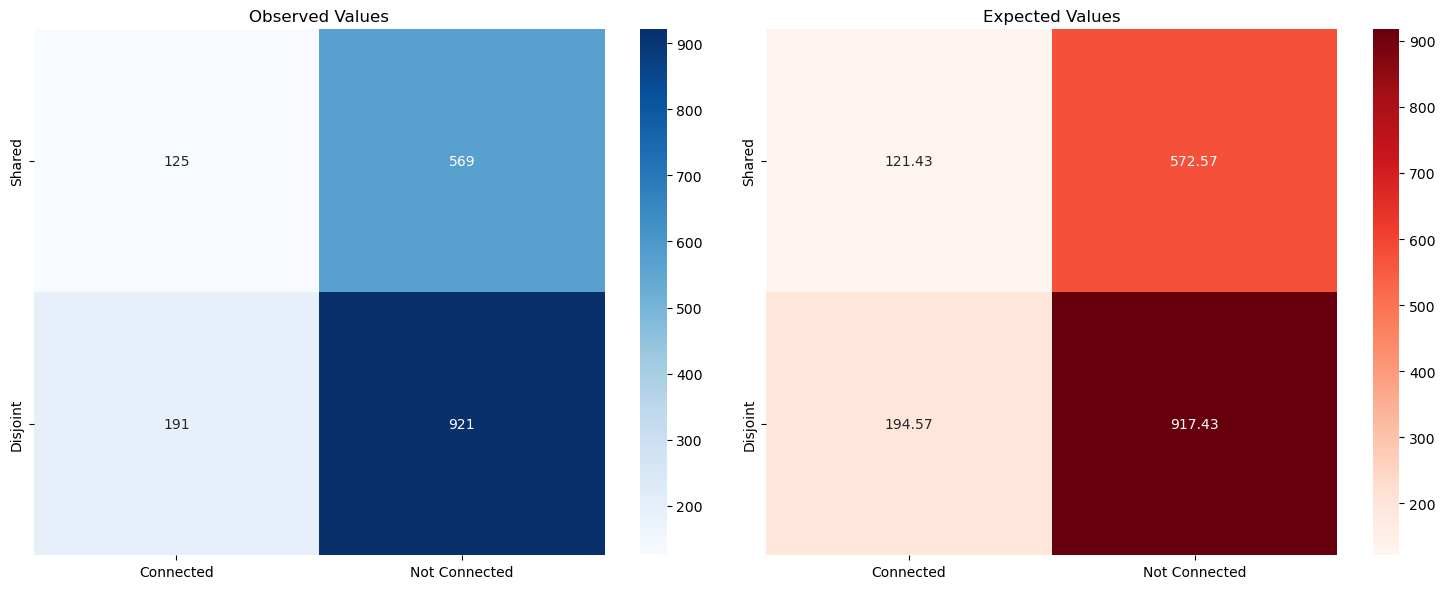

Chi-squared Statistic: 0.15
Degrees of Freedom: 1
P-value: 0.6960

Inhibitory Chain Contingency Table:
          Connected  Not Connected
Shared          694              0
Disjoint       1111              1


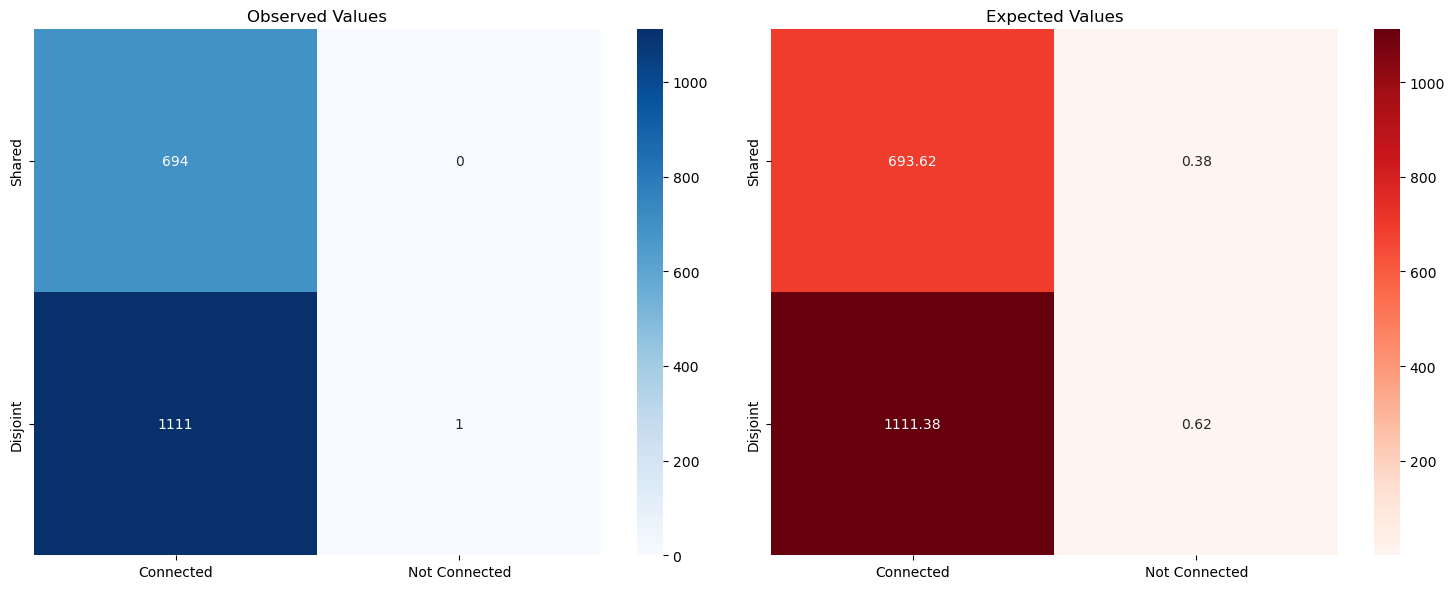

Chi-squared Statistic: 0.00
Degrees of Freedom: 1
P-value: 1.0000


In [75]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns


def chi_squared_analysis(data):
    """
    Perform a chi-squared test of independence on a contingency table, visualize observed and expected values,
    and display the chi-squared test statistic, degrees of freedom, and p-value.

    Parameters:
    data (pd.DataFrame): A DataFrame representing the contingency table.

    """
    # Perform the chi-squared test
    chi2, p, dof, expected = stats.chi2_contingency(data)

    # Convert expected values to DataFrame for easy visualization
    expected_df = pd.DataFrame(expected, index=data.index, columns=data.columns)

    # Plot observed and expected values side by side
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    sns.heatmap(data, annot=True, fmt=".0f", cmap="Blues", ax=axes[0])
    axes[0].set_title("Observed Values")

    sns.heatmap(expected_df, annot=True, fmt=".2f", cmap="Reds", ax=axes[1])
    axes[1].set_title("Expected Values")

    plt.tight_layout()
    plt.show()

    # Display the chi-squared test results
    print(f"Chi-squared Statistic: {chi2:.2f}")
    print(f"Degrees of Freedom: {dof}")
    print(f"P-value: {p:.4f}")

    
    
excitatory_shared_connected = sum(1 for pair, val in B_pair_excitatory['shared'].items() if val == 1)
excitatory_shared_not_connected = sum(1 for pair, val in B_pair_excitatory['shared'].items() if val == 0)
excitatory_disjoint_connected = sum(1 for pair, val in B_pair_excitatory['disjoint'].items() if val == 1)
excitatory_disjoint_not_connected = sum(1 for pair, val in B_pair_excitatory['disjoint'].items() if val == 0)

excitatory_contingency_table = pd.DataFrame({
    'Connected': [excitatory_shared_connected, excitatory_disjoint_connected],
    'Not Connected': [excitatory_shared_not_connected, excitatory_disjoint_not_connected]
}, index=['Shared', 'Disjoint'])

print("Excitatory Chain Contingency Table:")
print(excitatory_contingency_table)
chi_squared_analysis(excitatory_contingency_table)  # Perform chi-squared analysis for excitatory chains

# Inhibitory Chain Contingency Table
inhibitory_shared_connected = sum(1 for pair, val in B_pair_inhibitory['shared'].items() if val == 1)
inhibitory_shared_not_connected = sum(1 for pair, val in B_pair_inhibitory['shared'].items() if val == 0)
inhibitory_disjoint_connected = sum(1 for pair, val in B_pair_inhibitory['disjoint'].items() if val == 1)
inhibitory_disjoint_not_connected = sum(1 for pair, val in B_pair_inhibitory['disjoint'].items() if val == 0)

inhibitory_contingency_table = pd.DataFrame({
    'Connected': [inhibitory_shared_connected, inhibitory_disjoint_connected],
    'Not Connected': [inhibitory_shared_not_connected, inhibitory_disjoint_not_connected]
}, index=['Shared', 'Disjoint'])

print("\nInhibitory Chain Contingency Table:")
print(inhibitory_contingency_table)
chi_squared_analysis(inhibitory_contingency_table)  # Perform chi-squared analysis for inhibitory chains

### Inhibitory-Outbound

In [85]:
# Levene and T-test

from scipy.stats import ttest_ind, levene, ranksums, wilcoxon

print('\n\nLevene and T-test on OUTBOUND PSDS for Feed-Forward Inhibitory CHAINS normalized based on middle cell')
for c1 in C:
    for c2 in C:
        if c1.__name__ != c2.__name__:
            print(f'\n{c1.__name__} vs {c2.__name__}')
            result = stats.levene(list(W_out_feed_forward_inhibition_chains[c1.__name__].values()), list(W_out_feed_forward_inhibition_chains[c2.__name__].values()))
            
            
            print(result)
            if result.pvalue < 0.05:
                plt.figure()
                plt.boxplot([list(W_out_feed_forward_inhibition_chains[c1.__name__].values()), list(W_out_feed_forward_inhibition_chains[c2.__name__].values())])
                plt.title(f'Levene test for equal variance: {c1.__name__} vs {c2.__name__}')


            result_log10 = stats.levene(np.log10(list(W_out_feed_forward_inhibition_chains[c1.__name__].values())), np.log10(list(W_out_feed_forward_inhibition_chains[c2.__name__].values())))
            
            
            print(result_log10)
            if result_log10.pvalue < 0.05:
                plt.figure()
                plt.boxplot([np.log10(list(W_out_feed_forward_inhibition_chains[c1.__name__].values())),np.log10(list(W_out_feed_forward_inhibition_chains[c2.__name__].values()))])
                plt.title(f'Levene test for equal variance: {c1.__name__} vs {c2.__name__}')

            result2  = stats.ttest_ind(np.log10(list(W_out_feed_forward_inhibition_chains[c1.__name__].values())), 
                                 np.log10(list(W_out_feed_forward_inhibition_chains[c2.__name__].values())), equal_var=True, alternative='greater')
            
            print("Greater")
            print(result2)
            if result2.pvalue < 0.05:
                plt.figure()
                plt.boxplot([np.log10(list(W_out_feed_forward_inhibition_chains[c1.__name__].values())), 
                                 np.log10(list(W_out_feed_forward_inhibition_chains[c2.__name__].values()))])
                plt.title(f'T-test : {c1.__name__} vs {c2.__name__}')




Levene and T-test on OUTBOUND PSDS for Feed-Forward Inhibitory CHAINS normalized based on middle cell

shared vs disjoint
LeveneResult(statistic=0.5390040212399373, pvalue=0.4649399497772029)
LeveneResult(statistic=0.7981438497459001, pvalue=0.37426343314413146)
Greater
Ttest_indResult(statistic=-0.5525600916925024, pvalue=0.7089661017453568)

shared vs shared_no_a
LeveneResult(statistic=0.6667053063081242, pvalue=0.41800038426987207)
LeveneResult(statistic=0.9387109520971625, pvalue=0.3371820835327729)
Greater
Ttest_indResult(statistic=-0.24815674882650332, pvalue=0.5974951860901028)

shared vs no_a_a
LeveneResult(statistic=2.2863454416643316, pvalue=0.13668923161104082)
LeveneResult(statistic=3.0083070566106587, pvalue=0.08887977872493795)
Greater
Ttest_indResult(statistic=-0.27671062167923455, pvalue=0.6084396427057507)

shared vs a_no_a
LeveneResult(statistic=0.1518742267589401, pvalue=0.6977610346074787)
LeveneResult(statistic=0.10367809933770346, pvalue=0.7482790643126522)
Grea

**Signed ranksums on non-zero summed PSD (by cell)**



Wilcoxon Ranksums for Feed-Forward Inhibitory CHAINS normalized based on middle cell (INHIBITORY, OUTBOUND)

shared vs disjoint
Greater:
WilcoxonResult(statistic=298.0, pvalue=0.9575781013013511)

shared vs shared_no_a
Greater:
WilcoxonResult(statistic=nan, pvalue=nan)

shared vs no_a_a
Greater:
WilcoxonResult(statistic=nan, pvalue=nan)

shared vs a_no_a
Greater:
WilcoxonResult(statistic=408.0, pvalue=0.6159599168131535)

disjoint vs shared
Greater:
WilcoxonResult(statistic=563.0, pvalue=0.0436326305593866)

disjoint vs shared_no_a
Greater:
WilcoxonResult(statistic=nan, pvalue=nan)

disjoint vs no_a_a
Greater:
WilcoxonResult(statistic=nan, pvalue=nan)

disjoint vs a_no_a
Greater:
WilcoxonResult(statistic=638.0, pvalue=0.023122228269016887)

shared_no_a vs shared
Greater:
WilcoxonResult(statistic=nan, pvalue=nan)

shared_no_a vs disjoint
Greater:
WilcoxonResult(statistic=nan, pvalue=nan)

shared_no_a vs no_a_a
Greater:
WilcoxonResult(statistic=32.0, pvalue=0.71533203125)

shared_no_a 

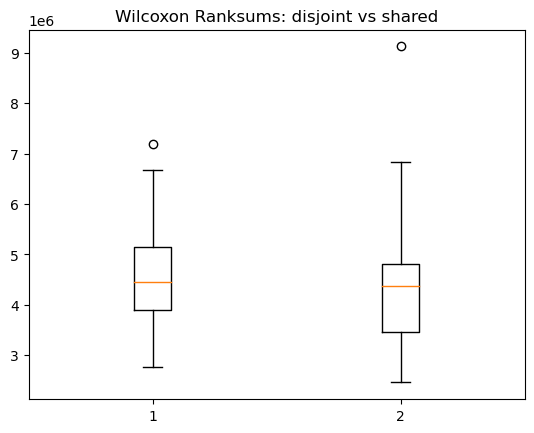

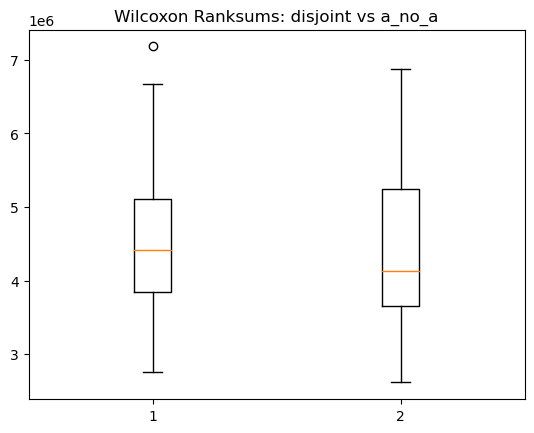

In [86]:
# Wilcoxon Summed PSDs

# Outbound Summed PSDs

print('\n\nWilcoxon Ranksums for Feed-Forward Inhibitory CHAINS normalized based on middle cell (INHIBITORY, OUTBOUND)')
for c1 in C:
    for c2 in C:
        if c1.__name__ != c2.__name__:
            print(f'\n{c1.__name__} vs {c2.__name__}')
             # Find common cells for matched pairs analysis
            common_cells = set(W_out_feed_forward_inhibition_chains[c1.__name__].keys()) & set(W_out_feed_forward_inhibition_chains[c2.__name__].keys())
            W_out_feed_forward_inhibition_chains_matched = [W_out_feed_forward_inhibition_chains[c1.__name__][cell] for cell in common_cells]
            W_out_feed_forward_inhibition_chains_matched2 = [W_out_feed_forward_inhibition_chains[c2.__name__][cell] for cell in common_cells]
            
            result = stats.wilcoxon((W_out_feed_forward_inhibition_chains_matched), (W_out_feed_forward_inhibition_chains_matched2), alternative='greater')

            print('Greater:')
            print(result)
            if result.pvalue < 0.05:
                plt.figure()
                plt.boxplot([list(W_out_feed_forward_inhibition_chains_matched), list(W_out_feed_forward_inhibition_chains_matched2)])
                plt.title(f'Wilcoxon Ranksums: {c1.__name__} vs {c2.__name__}')

In [ ]:
##---------MATCHES

**Signed Ranksums of cells based on probability of connections- by cell**



Wilcoxon Ranksums for Feed-Forward Inhibitory CHAINS Connection Probability (INHIBITORY, OUTBOUND)

shared vs disjoint
Greater:
WilcoxonResult(statistic=702.0, pvalue=0.00012810193493351107)

shared vs shared_no_a
Greater:
WilcoxonResult(statistic=nan, pvalue=nan)

shared vs no_a_a
Greater:
WilcoxonResult(statistic=nan, pvalue=nan)

shared vs a_no_a
Greater:
WilcoxonResult(statistic=584.0, pvalue=0.009672579041945007)

disjoint vs shared
Greater:
WilcoxonResult(statistic=159.0, pvalue=0.9998792628762203)

disjoint vs shared_no_a
Greater:
WilcoxonResult(statistic=nan, pvalue=nan)

disjoint vs no_a_a
Greater:
WilcoxonResult(statistic=nan, pvalue=nan)

disjoint vs a_no_a
Greater:
WilcoxonResult(statistic=207.0, pvalue=0.9995385546640136)

shared_no_a vs shared
Greater:
WilcoxonResult(statistic=nan, pvalue=nan)

shared_no_a vs disjoint
Greater:
WilcoxonResult(statistic=nan, pvalue=nan)

shared_no_a vs no_a_a
Greater:
WilcoxonResult(statistic=23.0, pvalue=0.898193359375)

shared_no_a vs a

c:\Users\saika\anaconda3\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
c:\Users\saika\anaconda3\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


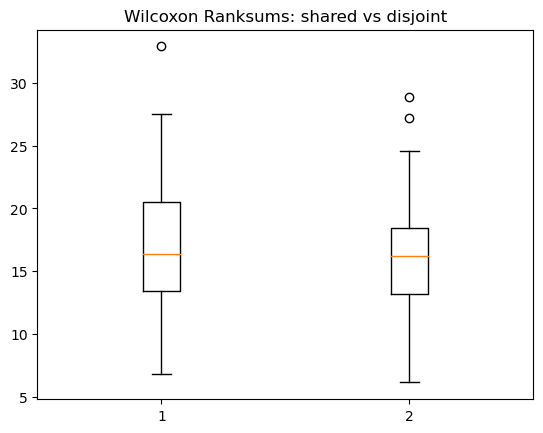

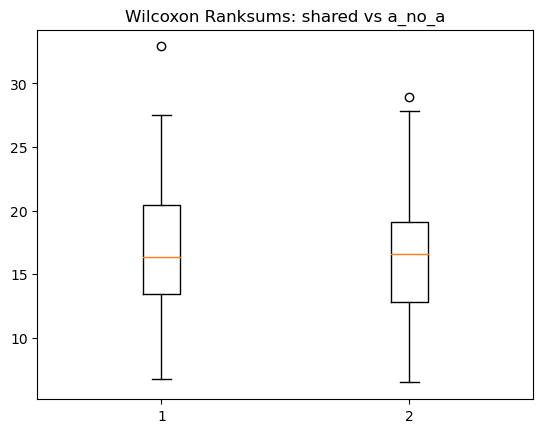

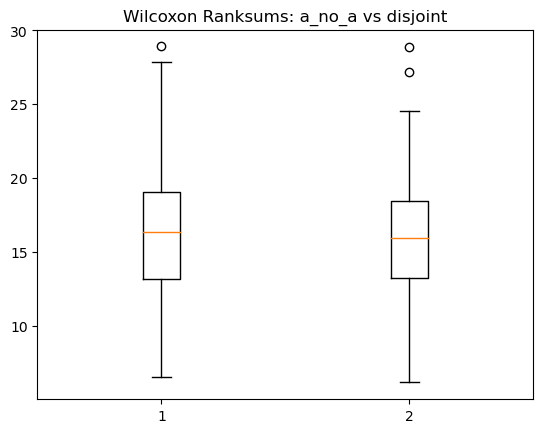

In [87]:
# Wilcoxon Summed PSDs

# Outbound Summed PSDs

print('\n\nWilcoxon Ranksums for Feed-Forward Inhibitory CHAINS Connection Probability (INHIBITORY, OUTBOUND)')
for c1 in C:
    for c2 in C:
        if c1.__name__ != c2.__name__:
            print(f'\n{c1.__name__} vs {c2.__name__}')
             # Find common cells for matched pairs analysis
            common_cells = set(B_chain_out_inhibitory[c1.__name__].keys()) & set(B_chain_out_inhibitory[c2.__name__].keys())
            B_chain_out_inhibitory_matched = [B_chain_out_inhibitory[c1.__name__][cell] for cell in common_cells]
            B_chain_out_inhibitory_matched2 = [B_chain_out_inhibitory[c2.__name__][cell] for cell in common_cells]
            
            result = stats.wilcoxon((B_chain_out_inhibitory_matched), (B_chain_out_inhibitory_matched2), alternative='greater')

            print('Greater:')
            print(result)
            if result.pvalue < 0.05:
                plt.figure()
                plt.boxplot([list(B_chain_out_inhibitory_matched), list(B_chain_out_inhibitory_matched2)])
                plt.title(f'Wilcoxon Ranksums: {c1.__name__} vs {c2.__name__}')

In [ ]:
#Inhibitory, Outbound, connection probability matches

**Un-signed ranksums of cells based on probability of connection**

In [88]:
print('\n\nWilcoxon Rank-Sum Test (Un-signed) for Connection Probability (Inhibitory, Outbound)')
for c1 in C:
    for c2 in C:
        if c1.__name__ != c2.__name__:
            print(f'\n{c1.__name__} vs {c2.__name__}')
            result = stats.ranksums(list(B_chain_out_inhibitory[c1.__name__].values()), list(B_chain_out_inhibitory[c2.__name__].values()), alternative='greater')

            print('Greater:')
            print(result)
            if result.pvalue < 0.05:
                plt.figure()
                plt.boxplot([list(B_chain_out_inhibitory[c1.__name__].values()), list(B_chain_out_inhibitory[c2.__name__].values())])
                plt.title(f'OUTBOUND SUMMED PSDS: {c1.__name__} vs {c2.__name__}')



Wilcoxon Rank-Sum Test (Un-signed) for Connection Probability (Inhibitory, Outbound)

shared vs disjoint
Greater:
RanksumsResult(statistic=0.9127570073734625, pvalue=0.18068517713644344)

shared vs shared_no_a
Greater:
RanksumsResult(statistic=0.9776176266971187, pvalue=0.16413173804668407)

shared vs no_a_a
Greater:
RanksumsResult(statistic=0.7650920556760059, pvalue=0.22210836506930337)

shared vs a_no_a
Greater:
RanksumsResult(statistic=0.26398364428938376, pvalue=0.3958962609073153)

disjoint vs shared
Greater:
RanksumsResult(statistic=-0.9127570073734625, pvalue=0.8193148228635565)

disjoint vs shared_no_a
Greater:
RanksumsResult(statistic=0.32605565837568895, pvalue=0.37219112237689633)

disjoint vs no_a_a
Greater:
RanksumsResult(statistic=0.12227087189088336, pvalue=0.4513422498734747)

disjoint vs a_no_a
Greater:
RanksumsResult(statistic=-0.5398120295844531, pvalue=0.7053366649120325)

shared_no_a vs shared
Greater:
RanksumsResult(statistic=-0.9776176266971187, pvalue=0.83586

In [ ]:
#wILCoxon Rank-Sum Test (Unmatched Data) for Connection Probability (Inhibitory, Outbound)MATCHES - does not match now

**Un-signed ranksums on Summed PSD's for non-zero summed PSD connections (by cell)**

In [80]:
# Outbound Summed PSDs

print('\n\nSUMMED OUTBOUND PSDS for Feed-Forward Inhibitory CHAINS normalized based on middle cell')
for c1 in C:
    for c2 in C:
        if c1.__name__ != c2.__name__:
            print(f'\n{c1.__name__} vs {c2.__name__}')
            result = stats.ranksums(list(W_out_feed_forward_inhibition_chains[c1.__name__].values()), list(W_out_feed_forward_inhibition_chains[c2.__name__].values()), alternative='greater')

            print('Greater:')
            print(result)
            if result.pvalue < 0.05:
                plt.figure()
                plt.boxplot([list(W_out_feed_forward_inhibition_chains[c1.__name__].values()), list(W_out_feed_forward_inhibition_chains[c2.__name__].values())])
                plt.title(f'OUTBOUND SUMMED PSDS: {c1.__name__} vs {c2.__name__}')



SUMMED OUTBOUND PSDS for Feed-Forward Inhibitory CHAINS normalized based on middle cell

shared vs disjoint
Greater:
RanksumsResult(statistic=-0.5234929895230153, pvalue=0.6996843858393493)

shared vs shared_no_a
Greater:
RanksumsResult(statistic=-0.12751534261266764, pvalue=0.5507337346707242)

shared vs no_a_a
Greater:
RanksumsResult(statistic=-0.27628324232744655, pvalue=0.6088347370593239)

shared vs a_no_a
Greater:
RanksumsResult(statistic=-0.022371495278761335, pvalue=0.5089241909341238)

disjoint vs shared
Greater:
RanksumsResult(statistic=0.5234929895230153, pvalue=0.3003156141606507)

disjoint vs shared_no_a
Greater:
RanksumsResult(statistic=0.26492022243024727, pvalue=0.39553545975645366)

disjoint vs no_a_a
Greater:
RanksumsResult(statistic=0.16302782918784448, pvalue=0.43524826163304664)

disjoint vs a_no_a
Greater:
RanksumsResult(statistic=0.5829969919512094, pvalue=0.2799476625986654)

shared_no_a vs shared
Greater:
RanksumsResult(statistic=0.12751534261266764, pvalue=0

### **EXCITATORY - OUTBOUND**

In [65]:
# Levene and T-test

from scipy.stats import ttest_ind, levene, ranksums, wilcoxon

print('\n\nLevene and T-test on OUTBOUND PSDS for Excitatory CHAINS normalized based on middle cell')
for c1 in C:
    for c2 in C:
        if c1.__name__ != c2.__name__:
            print(f'\n{c1.__name__} vs {c2.__name__}')
            # result = stats.levene(list(W_out_excitatory_chains[c1.__name__].values()), list(W_out_excitatory_chains[c2.__name__].values()))  #has some significance but wasn't part of tests 
            
            
            # print(result)
            # if result.pvalue < 0.05:
            #     plt.figure()
            #     plt.boxplot([list(W_out_excitatory_chains[c1.__name__].values()), list(W_out_excitatory_chains[c2.__name__].values())])
            #     plt.title(f'Levene test for equal variance: {c1.__name__} vs {c2.__name__}')


            result_log10 = stats.levene(np.log10(list(W_out_excitatory_chains[c1.__name__].values())), np.log10(list(W_out_excitatory_chains[c2.__name__].values())))
            
            
            print(result_log10)
            if result_log10.pvalue < 0.05:
                plt.figure()
                plt.boxplot([np.log10(list(W_out_excitatory_chains[c1.__name__].values())),np.log10(list(W_out_excitatory_chains[c2.__name__].values()))])
                plt.title(f'Levene test for equal variance: {c1.__name__} vs {c2.__name__}')

            result2  = stats.ttest_ind(np.log10(list(W_out_excitatory_chains[c1.__name__].values())), 
                                 np.log10(list(W_out_excitatory_chains[c2.__name__].values())), equal_var=True, alternative='greater')
            
            print("Greater")
            print(result2)
            if result2.pvalue < 0.05:
                plt.figure()
                plt.boxplot([np.log10(list(W_out_excitatory_chains[c1.__name__].values())), 
                                 np.log10(list(W_out_excitatory_chains[c2.__name__].values()))])
                plt.title(f'T-test : {c1.__name__} vs {c2.__name__}')



Levene and T-test on OUTBOUND PSDS for Excitatory CHAINS normalized based on middle cell

shared vs disjoint
LeveneResult(statistic=0.27694129032917597, pvalue=0.6003531394765236)
Greater
Ttest_indResult(statistic=1.6465751770151231, pvalue=0.05203251863335755)

shared vs shared_no_a
LeveneResult(statistic=0.8106290186505548, pvalue=0.3734605738005833)
Greater
Ttest_indResult(statistic=0.9214193647810294, pvalue=0.18124829134768283)

shared vs no_a_a
LeveneResult(statistic=0.5147165518314166, pvalue=0.47698374238324237)
Greater
Ttest_indResult(statistic=-0.1756008279522195, pvalue=0.5692840565205279)

shared vs a_no_a
LeveneResult(statistic=0.045269357099204294, pvalue=0.8321857592022964)
Greater
Ttest_indResult(statistic=0.6486616008779391, pvalue=0.2594389747966195)

disjoint vs shared
LeveneResult(statistic=0.27694129032917597, pvalue=0.6003531394765236)
Greater
Ttest_indResult(statistic=-1.6465751770151231, pvalue=0.9479674813666424)

disjoint vs shared_no_a
LeveneResult(statisti

**Test:  Signed ranksums on non-zero summed PSD (by cell)**

In [89]:
# Wilcoxon Excitatory

# Outbound Summed PSDs

print('\n\nWilcoxon Signed Ranksums for Excitatory CHAINS normalized based on middle cell')
for c1 in C:
    for c2 in C:
        if c1.__name__ != c2.__name__:
            print(f'\n{c1.__name__} vs {c2.__name__}')
             # Find common cells for matched pairs analysis
            common_cells = set(W_out_excitatory_chains[c1.__name__].keys()) & set(W_out_excitatory_chains[c2.__name__].keys())
            W_out_excitatory_chains_matched = [W_out_excitatory_chains[c1.__name__][cell] for cell in common_cells]
            W_out_excitatory_chains_matched2 = [W_out_excitatory_chains[c2.__name__][cell] for cell in common_cells]
            
            result = stats.wilcoxon((W_out_excitatory_chains_matched), (W_out_excitatory_chains_matched2), alternative='greater')

            print('Greater:')
            print(result)
            if result.pvalue < 0.05:
                plt.figure()
                plt.boxplot([list(W_out_excitatory_chains_matched), list(W_out_excitatory_chains_matched2)])
                plt.title(f'Wilcoxon Ranksums: {c1.__name__} vs {c2.__name__}')



Wilcoxon Signed Ranksums for Excitatory CHAINS normalized based on middle cell

shared vs disjoint
Greater:
WilcoxonResult(statistic=293.0, pvalue=0.11032337881624699)

shared vs shared_no_a
Greater:
WilcoxonResult(statistic=nan, pvalue=nan)

shared vs no_a_a
Greater:
WilcoxonResult(statistic=nan, pvalue=nan)

shared vs a_no_a
Greater:
WilcoxonResult(statistic=175.0, pvalue=0.3754964768886566)

disjoint vs shared
Greater:
WilcoxonResult(statistic=172.0, pvalue=0.8935335734859109)

disjoint vs shared_no_a
Greater:
WilcoxonResult(statistic=nan, pvalue=nan)

disjoint vs no_a_a
Greater:
WilcoxonResult(statistic=nan, pvalue=nan)

disjoint vs a_no_a
Greater:
WilcoxonResult(statistic=191.0, pvalue=0.9141919752582908)

shared_no_a vs shared
Greater:
WilcoxonResult(statistic=nan, pvalue=nan)

shared_no_a vs disjoint
Greater:
WilcoxonResult(statistic=nan, pvalue=nan)

shared_no_a vs no_a_a
Greater:
WilcoxonResult(statistic=22.0, pvalue=0.3203125)

shared_no_a vs a_no_a
Greater:
WilcoxonResult(

In [ ]:
###MATCHES

**Signed Ranksums of cells based on probability of connections- by cell**

In [90]:
# Wilcoxon Excitatory



print('\n\nWilcoxon Signed Ranksums for Excitatory CHAINS Connection Probability - OUTBOUND')
for c1 in C:
    for c2 in C:
        if c1.__name__ != c2.__name__:
            print(f'\n{c1.__name__} vs {c2.__name__}')
             # Find common cells for matched pairs analysis
            common_cells = set(B_chain_out_excitatory[c1.__name__].keys()) & set(B_chain_out_excitatory[c2.__name__].keys())
            B_chain_out_excitatory_matched = [B_chain_out_excitatory[c1.__name__][cell] for cell in common_cells]
            B_chain_out_excitatory_matched2 = [B_chain_out_excitatory[c2.__name__][cell] for cell in common_cells]
            
            result = stats.wilcoxon((B_chain_out_excitatory_matched), (B_chain_out_excitatory_matched2), alternative='greater')

            print('Greater:')
            print(result)
            if result.pvalue < 0.05:
                plt.figure()
                plt.boxplot([list(B_chain_out_excitatory_matched), list(B_chain_out_excitatory_matched2)])
                plt.title(f'Wilcoxon Ranksums: {c1.__name__} vs {c2.__name__}')



Wilcoxon Signed Ranksums for Excitatory CHAINS Connection Probability - OUTBOUND

shared vs disjoint
Greater:
WilcoxonResult(statistic=414.0, pvalue=0.4785608803212824)

shared vs shared_no_a
Greater:
WilcoxonResult(statistic=nan, pvalue=nan)

shared vs no_a_a
Greater:
WilcoxonResult(statistic=nan, pvalue=nan)

shared vs a_no_a
Greater:
WilcoxonResult(statistic=403.5, pvalue=0.42527641084499573)

disjoint vs shared
Greater:
WilcoxonResult(statistic=406.0, pvalue=0.5214391196787176)

disjoint vs shared_no_a
Greater:
WilcoxonResult(statistic=nan, pvalue=nan)

disjoint vs no_a_a
Greater:
WilcoxonResult(statistic=nan, pvalue=nan)

disjoint vs a_no_a
Greater:
WilcoxonResult(statistic=377.0, pvalue=0.5719833993816518)

shared_no_a vs shared
Greater:
WilcoxonResult(statistic=nan, pvalue=nan)

shared_no_a vs disjoint
Greater:
WilcoxonResult(statistic=nan, pvalue=nan)

shared_no_a vs no_a_a
Greater:
WilcoxonResult(statistic=33.0, pvalue=0.68896484375)

shared_no_a vs a_no_a
Greater:
WilcoxonR

c:\Users\saika\anaconda3\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


In [ ]:
### DOES NOT MATCH EVEN AFTER CORRECTION
###Wilcoxon Signed-Rank Test (Matched Pairs) for Connection Probability (Excitatory, Outbound)
##Test Statistic: 414.0 p-value: 0.4785608803212824

**Un-Signed Ranksums of chains based on probability of connections- by cell**

In [91]:
# Outbound Conn Probability

print('\n\nWilcoxon Rank-Sum Test (Unsigned) for Excitatory cells based on Connection Probability - OUTBOUND')
for c1 in C:
    for c2 in C:
        if c1.__name__ != c2.__name__:
            print(f'\n{c1.__name__} vs {c2.__name__}')
            result = stats.ranksums(list(B_chain_out_excitatory[c1.__name__].values()), list(B_chain_out_excitatory[c2.__name__].values()), alternative='greater')
            print('Greater:')
            print(result)
            if result.pvalue < 0.05:
                plt.figure()
                plt.boxplot([list(B_chain_out_excitatory[c1.__name__].values()), list(B_chain_out_excitatory[c2.__name__].values())])
                plt.title(f'Wilcoxon Rank-Sum Test (Un-signed) for Connection Probability: {c1.__name__} vs {c2.__name__}')



Wilcoxon Rank-Sum Test (Unsigned) for Excitatory cells based on Connection Probability - OUTBOUND

shared vs disjoint
Greater:
RanksumsResult(statistic=-0.21924065373186108, pvalue=0.5867687056855773)

shared vs shared_no_a
Greater:
RanksumsResult(statistic=1.2539008690245652, pvalue=0.10493901956946189)

shared vs no_a_a
Greater:
RanksumsResult(statistic=0.38254602783800296, pvalue=0.3510281974634707)

shared vs a_no_a
Greater:
RanksumsResult(statistic=0.3132009339026587, pvalue=0.3770640044730793)

disjoint vs shared
Greater:
RanksumsResult(statistic=0.21924065373186108, pvalue=0.41323129431442274)

disjoint vs shared_no_a
Greater:
RanksumsResult(statistic=1.2940333941785156, pvalue=0.09782694310730744)

disjoint vs no_a_a
Greater:
RanksumsResult(statistic=0.6724897953998585, pvalue=0.2506359672040792)

disjoint vs a_no_a
Greater:
RanksumsResult(statistic=0.22888030054380812, pvalue=0.40948097603507994)

shared_no_a vs shared
Greater:
RanksumsResult(statistic=-1.2539008690245652, p

In [ ]:
######not matching EVEN AFTER CORRECTION  ####
### Wilcoxon Rank-Sum Test (Unmatched Data) for Connection Probability (Excitatory, Outbound)
##Test Statistic: -0.21924065373186108 p-value: 0.5867687056855773

**Un-signed ranksums of non-zero summed PSD's - by cell**

In [92]:
# Outbound Summed PSDs

print('\n\nSUMMED OUTBOUND PSDS for Excitatory CHAINS normalized based on middle cell')
for c1 in C:
    for c2 in C:
        if c1.__name__ != c2.__name__:
            print(f'\n{c1.__name__} vs {c2.__name__}')
            result = stats.ranksums(list(W_out_excitatory_chains[c1.__name__].values()), list(W_out_excitatory_chains[c2.__name__].values()), alternative='greater')
            print('Greater:')
            print(result)
            if result.pvalue < 0.05:
                plt.figure()
                plt.boxplot([list(W_out_excitatory_chains[c1.__name__].values()), list(W_out_excitatory_chains[c2.__name__].values())])
                plt.title(f'OUTBOUND SUMMED PSDS: {c1.__name__} vs {c2.__name__}')



SUMMED OUTBOUND PSDS for Excitatory CHAINS normalized based on middle cell

shared vs disjoint
Greater:
RanksumsResult(statistic=1.3411370730274548, pvalue=0.08993797627996997)

shared vs shared_no_a
Greater:
RanksumsResult(statistic=0.7895420339517227, pvalue=0.21489763616977792)

shared vs no_a_a
Greater:
RanksumsResult(statistic=-0.384995251754509, pvalue=0.6498795332706171)

shared vs a_no_a
Greater:
RanksumsResult(statistic=0.2757260134719975, pvalue=0.39137925698933224)

disjoint vs shared
Greater:
RanksumsResult(statistic=-1.3411370730274548, pvalue=0.9100620237200301)

disjoint vs shared_no_a
Greater:
RanksumsResult(statistic=0.16598500055174645, pvalue=0.43408437712655834)

disjoint vs no_a_a
Greater:
RanksumsResult(statistic=-1.520302849670743, pvalue=0.9357825609161705)

disjoint vs a_no_a
Greater:
RanksumsResult(statistic=-1.1194615237667185, pvalue=0.8685283516870185)

shared_no_a vs shared
Greater:
RanksumsResult(statistic=-0.7895420339517227, pvalue=0.7851023638302221)

### **Inbound connectivity**

In [94]:
classification_map = cell_table.set_index('connectome_index')['classification_system'].to_dict() # Map to tell us if its Excitatory or Inhibitory 


# Calculate the weighted summed values

backup_assembly_pre_root_ids = assembly_pre_root_ids
backup_assembly_post_root_ids = assembly_post_root_ids




W_in_feed_forward_inhibition_chains = {c.__name__: {} for c in C}
W_in_excitatory_chains = {c.__name__: {} for c in C}

B_chain_in_inhibitory = {c.__name__: {} for c in C}
B_chain_in_excitatory = {c.__name__: {} for c in C}

for cond_function in C:
    for i in assembly_post_root_ids:
        # Exclude the current pre-synaptic cell from the post-synaptic candidate set
        #normalizing_factor = 0
      
        pre_root_ids = backup_assembly_pre_root_ids - set([i])
        potential_partners_in = {j for j in pre_root_ids if cond_function(j, i, A)}
        if potential_partners_in:
              normalizing_factor_excitatory_middle_cell = 0
              normalizing_factor_inhibitory_middle_cell = 0
              for j in potential_partners_in:
            # Check if pre-synaptic cell 'j' satisfies the condition with post-synaptic cell 'i'
                    if cond_function(j, i, A) and j != i:
                          pre_idx = mappings_a['pt_root_id_to_connectome_index'][j]
                          post_idx = mappings_a['pt_root_id_to_connectome_index'][i]

                # Filter chains where cell A in chain matches pre_idx and cell C matches post_idx
                          temporary_chain_results = two_chain_results_array[(two_chain_results_array[:, 0] == pre_idx) & (two_chain_results_array[:, 2] == post_idx)]

                # Add to the normalizing factor the number of realized chains between pre_cell (position A in chain) and post cell (position C in chain)
                          normalizing_factor += len(temporary_chain_results)

                # Continue if no matches are found
                          if len(temporary_chain_results) == 0:
                                continue

                          for chain in temporary_chain_results:  # Summing over possible intermediate nodes (k's)
                                 cell_a, cell_b, cell_c = chain

                    # Classification of the intermediate node (cell B)
                                 if classification_map[cell_b] == 'inhibitory':
                                   normalizing_factor_inhibitory_middle_cell += 1
                                   k = mappings_a['connectome_index_to_root_id'][cell_b]
                                   W_in_feed_forward_inhibition_chains[cond_function.__name__][i] = (W_in_feed_forward_inhibition_chains[cond_function.__name__].get(i, 0) +
                                    (w_jk[(j, k)]* w_ki[(k,i)]) )
                                   W_inhibitory[(j,i)] = W_in_feed_forward_inhibition_chains[cond_function.__name__][i]


                                 elif classification_map[cell_b] == 'excitatory':
                                    normalizing_factor_excitatory_middle_cell += 1
                                    k = mappings_a['connectome_index_to_root_id'][cell_b]
                                    W_in_excitatory_chains[cond_function.__name__][i] = (
                                    W_in_excitatory_chains[cond_function.__name__].get(i, 0) +
                                       (w_jkE[(j,k)]*w_kiE[(k,i)])
                                       )
                                    W_excitatory[(j,i)] = W_in_excitatory_chains[cond_function.__name__][i]

              if i in W_in_feed_forward_inhibition_chains[cond_function.__name__]:
                       W_in_feed_forward_inhibition_chains[cond_function.__name__][i] /= normalizing_factor_inhibitory_middle_cell

              B_chain_in_inhibitory[cond_function.__name__][i] = normalizing_factor_inhibitory_middle_cell / len(potential_partners_in) if len(potential_partners_in) > 0 else 0

              if i in W_in_excitatory_chains[cond_function.__name__]:
                       W_in_excitatory_chains[cond_function.__name__][i] /= normalizing_factor_excitatory_middle_cell

              B_chain_in_excitatory[cond_function.__name__][i] = normalizing_factor_excitatory_middle_cell / len(potential_partners_in) if len(potential_partners_in) > 0 else 0

### INHIBITORY - INBOUND

In [30]:
# Levene and T-test

from scipy.stats import ttest_ind, levene, ranksums, wilcoxon

print('\n\nLevene and T-test on INBOUND PSDS for Feed-Forward Inhibitory CHAINS normalized based on middle cell')
for c1 in C:
    for c2 in C:
        if c1.__name__ != c2.__name__:
            print(f'\n{c1.__name__} vs {c2.__name__}')
            result = stats.levene(list(W_in_feed_forward_inhibition_chains[c1.__name__].values()), list(W_in_feed_forward_inhibition_chains[c2.__name__].values()))
            
            
            print(result)
            if result.pvalue < 0.05:
                plt.figure()
                plt.boxplot([list(W_in_feed_forward_inhibition_chains[c1.__name__].values()), list(W_in_feed_forward_inhibition_chains[c2.__name__].values())])
                plt.title(f'Levene test for equal variance: {c1.__name__} vs {c2.__name__}')


            result_log10 = stats.levene(np.log10(list(W_in_feed_forward_inhibition_chains[c1.__name__].values())), np.log10(list(W_in_feed_forward_inhibition_chains[c2.__name__].values())))
            
            
            print(result_log10)
            if result_log10.pvalue < 0.05:
                plt.figure()
                plt.boxplot([np.log10(list(W_in_feed_forward_inhibition_chains[c1.__name__].values())),np.log10(list(W_in_feed_forward_inhibition_chains[c2.__name__].values()))])
                plt.title(f'Levene test for equal variance: {c1.__name__} vs {c2.__name__}')

            result2  = stats.ttest_ind(np.log10(list(W_in_feed_forward_inhibition_chains[c1.__name__].values())), 
                                 np.log10(list(W_in_feed_forward_inhibition_chains[c2.__name__].values())), equal_var=True, alternative='greater')
            
            print("Greater")
            print(result2)
            if result2.pvalue < 0.05:
                plt.figure()
                plt.boxplot([np.log10(list(W_in_feed_forward_inhibition_chains[c1.__name__].values())), 
                                 np.log10(list(W_in_feed_forward_inhibition_chains[c2.__name__].values()))])
                plt.title(f'T-test : {c1.__name__} vs {c2.__name__}')




Levene and T-test on INBOUND PSDS for Feed-Forward Inhibitory CHAINS normalized based on middle cell

shared vs disjoint
LeveneResult(statistic=0.09680963003934054, pvalue=0.7564819315205032)
LeveneResult(statistic=0.2729108943639057, pvalue=0.6027943048295366)
Greater
Ttest_indResult(statistic=-0.696451853610305, pvalue=0.7559422840154683)

shared vs shared_no_a
LeveneResult(statistic=0.010919771232268933, pvalue=0.9171842716908957)
LeveneResult(statistic=0.05604528639517801, pvalue=0.8138077112269528)
Greater
Ttest_indResult(statistic=-0.21018391940340395, pvalue=0.5828192041354854)

shared vs no_a_a
LeveneResult(statistic=0.00011870373643161417, pvalue=0.9913335841642231)
LeveneResult(statistic=0.005092107960941724, pvalue=0.9432857898179788)
Greater
Ttest_indResult(statistic=-0.006848989287502243, pvalue=0.5027240124004086)

shared vs a_no_a
LeveneResult(statistic=0.656364581858595, pvalue=0.4216106220679374)
LeveneResult(statistic=0.8774506862549345, pvalue=0.3533156428091758)
G

**Signed ranksums on non-zero summed PSDs - by cell**



Wilcoxon Ranksums for Feed-Forward Inhibitory CHAINS normalized based on middle cell (INBOUND)

shared vs disjoint
Greater:
WilcoxonResult(statistic=245.0, pvalue=0.9925933185013491)

shared vs shared_no_a
Greater:
WilcoxonResult(statistic=nan, pvalue=nan)

shared vs no_a_a
Greater:
WilcoxonResult(statistic=474.0, pvalue=0.29056218472442197)

shared vs a_no_a
Greater:
WilcoxonResult(statistic=nan, pvalue=nan)

disjoint vs shared
Greater:
WilcoxonResult(statistic=616.0, pvalue=0.0076923322421862395)

disjoint vs shared_no_a
Greater:
WilcoxonResult(statistic=nan, pvalue=nan)

disjoint vs no_a_a
Greater:
WilcoxonResult(statistic=650.0, pvalue=0.0160449443279731)

disjoint vs a_no_a
Greater:
WilcoxonResult(statistic=nan, pvalue=nan)

shared_no_a vs shared
Greater:
WilcoxonResult(statistic=nan, pvalue=nan)

shared_no_a vs disjoint
Greater:
WilcoxonResult(statistic=nan, pvalue=nan)

shared_no_a vs no_a_a
Greater:
WilcoxonResult(statistic=nan, pvalue=nan)

shared_no_a vs a_no_a
Greater:
Wil

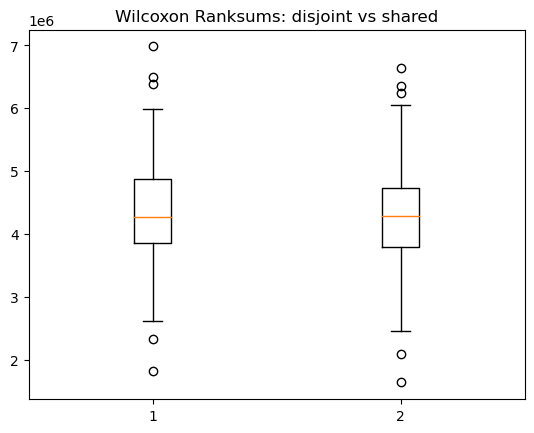

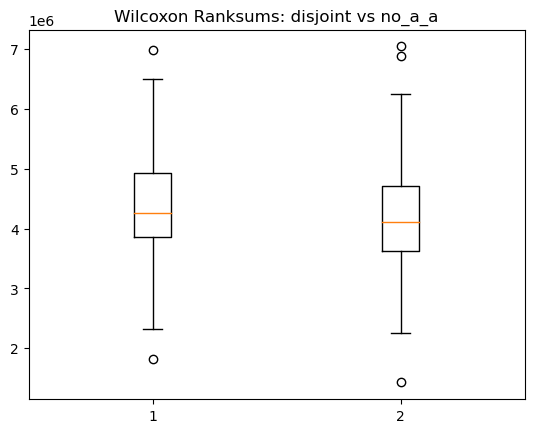

In [95]:
# Wilcoxon Summed PSDs

# Inbound 

print('\n\nWilcoxon Ranksums for Feed-Forward Inhibitory CHAINS normalized based on middle cell (INBOUND)')
for c1 in C:
    for c2 in C:
        if c1.__name__ != c2.__name__:
            print(f'\n{c1.__name__} vs {c2.__name__}')
             # Find common cells for matched pairs analysis
            common_cells = set(W_in_feed_forward_inhibition_chains[c1.__name__].keys()) & set(W_in_feed_forward_inhibition_chains[c2.__name__].keys())
            W_in_feed_forward_inhibition_chains_matched = [W_in_feed_forward_inhibition_chains[c1.__name__][cell] for cell in common_cells]
            W_in_feed_forward_inhibition_chains_matched2 = [W_in_feed_forward_inhibition_chains[c2.__name__][cell] for cell in common_cells]
            
            result = stats.wilcoxon((W_in_feed_forward_inhibition_chains_matched), (W_in_feed_forward_inhibition_chains_matched2), alternative='greater')

            print('Greater:')
            print(result)
            if result.pvalue < 0.05:
                plt.figure()
                plt.boxplot([list(W_in_feed_forward_inhibition_chains_matched), list(W_in_feed_forward_inhibition_chains_matched2)])
                plt.title(f'Wilcoxon Ranksums: {c1.__name__} vs {c2.__name__}')

In [ ]:
###------------inhibitory, inbound matches - wilcoxin, signed matches

**Signed ranksums for chains based on probability of connections**



Wilcoxon Ranksums(Signed) for Feed-Forward Inhibitory CHAINS Connection Probability

shared vs disjoint
Greater:
WilcoxonResult(statistic=426.0, pvalue=0.4148599747084314)

shared vs shared_no_a
Greater:
WilcoxonResult(statistic=nan, pvalue=nan)

shared vs no_a_a
Greater:
WilcoxonResult(statistic=731.0, pvalue=7.992565292141209e-06)

shared vs a_no_a
Greater:
WilcoxonResult(statistic=nan, pvalue=nan)

disjoint vs shared
Greater:
WilcoxonResult(statistic=394.0, pvalue=0.5851400252915686)

disjoint vs shared_no_a
Greater:
WilcoxonResult(statistic=nan, pvalue=nan)

disjoint vs no_a_a
Greater:
WilcoxonResult(statistic=877.0, pvalue=5.178080260425643e-08)

disjoint vs a_no_a
Greater:
WilcoxonResult(statistic=nan, pvalue=nan)

shared_no_a vs shared
Greater:
WilcoxonResult(statistic=nan, pvalue=nan)

shared_no_a vs disjoint
Greater:
WilcoxonResult(statistic=nan, pvalue=nan)

shared_no_a vs no_a_a
Greater:
WilcoxonResult(statistic=nan, pvalue=nan)

shared_no_a vs a_no_a
Greater:
WilcoxonResu

c:\Users\saika\anaconda3\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
c:\Users\saika\anaconda3\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
c:\Users\saika\anaconda3\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


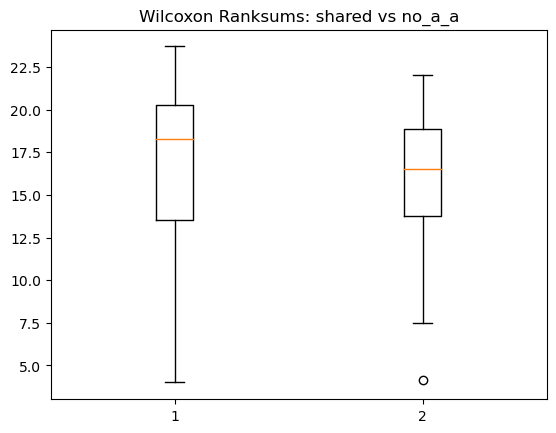

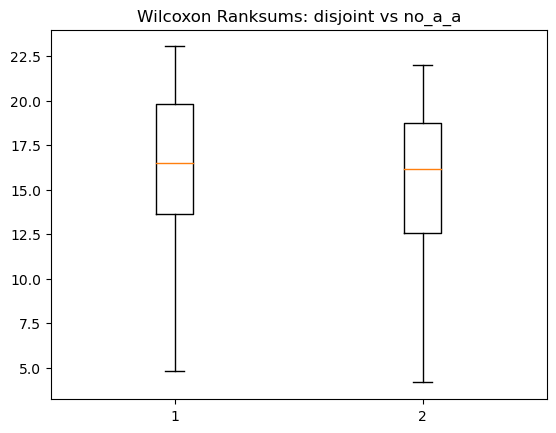

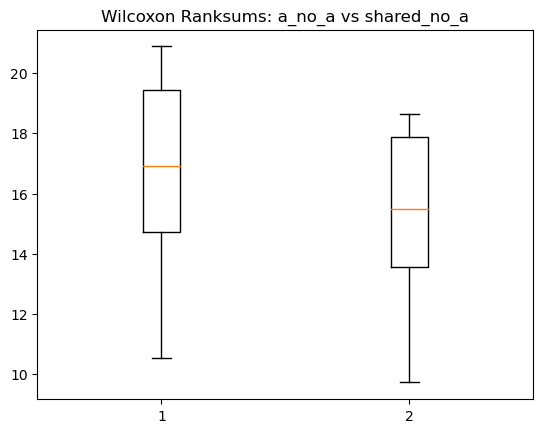

In [96]:
# Wilcoxon Summed PSDs

# Outbound Summed PSDs

print('\n\nWilcoxon Ranksums(Signed) for Feed-Forward Inhibitory CHAINS Connection Probability')
for c1 in C:
    for c2 in C:
        if c1.__name__ != c2.__name__:
            print(f'\n{c1.__name__} vs {c2.__name__}')
             # Find common cells for matched pairs analysis
            common_cells = set(B_chain_in_inhibitory[c1.__name__].keys()) & set(B_chain_in_inhibitory[c2.__name__].keys())
            B_chain_in_inhibitory_matched = [B_chain_in_inhibitory[c1.__name__][cell] for cell in common_cells]
            B_chain_in_inhibitory_matched2 = [B_chain_in_inhibitory[c2.__name__][cell] for cell in common_cells]
            
            result = stats.wilcoxon((B_chain_in_inhibitory_matched), (B_chain_in_inhibitory_matched2), alternative='greater')

            print('Greater:')
            print(result)
            if result.pvalue < 0.05:
                plt.figure()
                plt.boxplot([list(B_chain_in_inhibitory_matched), list(B_chain_in_inhibitory_matched2)])
                plt.title(f'Wilcoxon Ranksums: {c1.__name__} vs {c2.__name__}')

In [ ]:
### Inhibitory, inbound, signed conn-probability
# Statistic matches, p-value does not : Test Statistic: 426.0 p-value: 0.6250773763996559

**Un-signed ranksums for chains based on probability of connections**



Wilcoxin Ranksums(Un-signed) for Inhibitoryy CHAINS Connection Probability (INBOUND)

shared vs disjoint
Greater:
RanksumsResult(statistic=0.3668925225716859, pvalue=0.35684959461722426)

shared vs shared_no_a
Greater:
RanksumsResult(statistic=1.6045680612094013, pvalue=0.05429444747119439)

shared vs no_a_a
Greater:
RanksumsResult(statistic=1.8836799024717046, pvalue=0.029804143261845835)

shared vs a_no_a
Greater:
RanksumsResult(statistic=0.44630369914433676, pvalue=0.32768894227798284)

disjoint vs shared
Greater:
RanksumsResult(statistic=-0.3668925225716859, pvalue=0.6431504053827757)

disjoint vs shared_no_a
Greater:
RanksumsResult(statistic=1.3653580694481975, pvalue=0.08607026795047173)

disjoint vs no_a_a
Greater:
RanksumsResult(statistic=1.4855627054164149, pvalue=0.0686974129279004)

disjoint vs a_no_a
Greater:
RanksumsResult(statistic=0.12227087189088336, pvalue=0.4513422498734747)

shared_no_a vs shared
Greater:
RanksumsResult(statistic=-1.6045680612094013, pvalue=0.94570

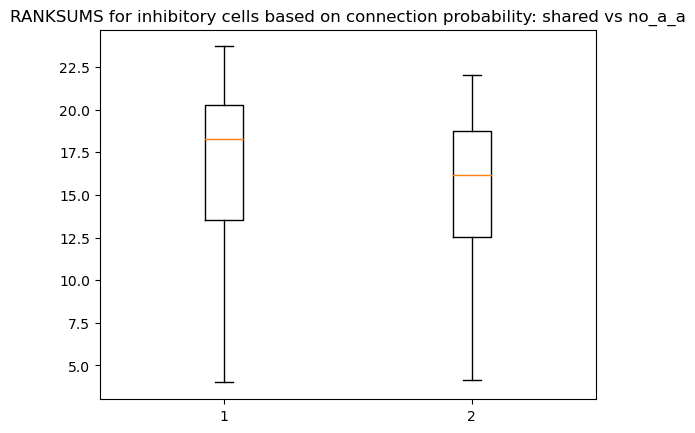

In [103]:
# Inbound Summed PSDs

print('\n\nWilcoxin Ranksums(Un-signed) for Inhibitoryy CHAINS Connection Probability (INBOUND)')
for c1 in C:
    for c2 in C:
        if c1.__name__ != c2.__name__:
            print(f'\n{c1.__name__} vs {c2.__name__}')
            result = stats.ranksums(list(B_chain_in_inhibitory[c1.__name__].values()), list(B_chain_in_inhibitory[c2.__name__].values()), alternative='greater')
            print('Greater:')
            print(result)
            if result.pvalue < 0.05:
                plt.figure()
                plt.boxplot([list(B_chain_in_inhibitory[c1.__name__].values()), list(B_chain_in_inhibitory[c2.__name__].values())])
                plt.title(f'RANKSUMS for inhibitory cells based on connection probability: {c1.__name__} vs {c2.__name__}')

In [ ]:
### -------------- INHIBITORY, INBOUND - UNSIGNED RANKSUM CONNECTION PROBABILITY DOES NOT MATCH
##---------------------- Test Statistic: -0.08369402990090917 p-value: 0.5333501480292843

**Un-signed ranksums for non-zero summed PSDs - by cell**

In [97]:
# Inbound Summed PSDs

print('\n\nSUMMED INBOUND PSDS for Feed-Forward Inhibitory CHAINS normalized based on middle cell')
for c1 in C:
    for c2 in C:
        if c1.__name__ != c2.__name__:
            print(f'\n{c1.__name__} vs {c2.__name__}')
            result = stats.ranksums(list(W_in_feed_forward_inhibition_chains[c1.__name__].values()), list(W_in_feed_forward_inhibition_chains[c2.__name__].values()), alternative='greater')

            print('Greater:')
            print(result)
            if result.pvalue < 0.05:
                plt.figure()
                plt.boxplot([list(W_in_feed_forward_inhibition_chains[c1.__name__].values()), list(W_in_feed_forward_inhibition_chains[c2.__name__].values())])
                plt.title(f'INBOUND SUMMED PSDS: {c1.__name__} vs {c2.__name__}')



SUMMED INBOUND PSDS for Feed-Forward Inhibitory CHAINS normalized based on middle cell

shared vs disjoint
Greater:
RanksumsResult(statistic=-0.5682359800805379, pvalue=0.7150626283661248)

shared vs shared_no_a
Greater:
RanksumsResult(statistic=-0.10626278551055637, pvalue=0.5423130713853782)

shared vs no_a_a
Greater:
RanksumsResult(statistic=0.4340070084079699, pvalue=0.33214167587785237)

shared vs a_no_a
Greater:
RanksumsResult(statistic=-0.4037985849401142, pvalue=0.6568195814246833)

disjoint vs shared
Greater:
RanksumsResult(statistic=0.5682359800805379, pvalue=0.2849373716338752)

disjoint vs shared_no_a
Greater:
RanksumsResult(statistic=0.3668126156726501, pvalue=0.356879398338411)

disjoint vs no_a_a
Greater:
RanksumsResult(statistic=0.9112027059385568, pvalue=0.18109428927916954)

disjoint vs a_no_a
Greater:
RanksumsResult(statistic=-0.12227087189088336, pvalue=0.5486577501265253)

shared_no_a vs shared
Greater:
RanksumsResult(statistic=0.10626278551055637, pvalue=0.45768

### Excitatory - Inbound

In [98]:
# Levene and T-test

from scipy.stats import ttest_ind, levene, ranksums, wilcoxon

print('\n\nLevene and T-test on Inbound PSDS for Excitatory CHAINS normalized based on middle cell (INBOUND)')
for c1 in C:
    for c2 in C:
        if c1.__name__ != c2.__name__:
            print(f'\n{c1.__name__} vs {c2.__name__}')
            # result = stats.levene(list(W_in_excitatory_chains[c1.__name__].values()), list(W_in_excitatory_chains[c2.__name__].values()))  #has some significance but wasn't part of tests 
            
            
            # print(result)
            # if result.pvalue < 0.05:
            #     plt.figure()
            #     plt.boxplot([list(W_in_excitatory_chains[c1.__name__].values()), list(W_in_excitatory_chains[c2.__name__].values())])
            #     plt.title(f'Levene test for equal variance: {c1.__name__} vs {c2.__name__}')


            result_log10 = stats.levene(np.log10(list(W_in_excitatory_chains[c1.__name__].values())), np.log10(list(W_in_excitatory_chains[c2.__name__].values())))
            
            
            print(result_log10)
            if result_log10.pvalue < 0.05:
                plt.figure()
                plt.boxplot([np.log10(list(W_in_excitatory_chains[c1.__name__].values())),np.log10(list(W_in_excitatory_chains[c2.__name__].values()))])
                plt.title(f'Levene test for equal variance: {c1.__name__} vs {c2.__name__}')

            result2  = stats.ttest_ind(np.log10(list(W_in_excitatory_chains[c1.__name__].values())), 
                                 np.log10(list(W_in_excitatory_chains[c2.__name__].values())), equal_var=True, alternative='greater')
            
            print("Greater")
            print(result2)
            if result2.pvalue < 0.05:
                plt.figure()
                plt.boxplot([np.log10(list(W_in_excitatory_chains[c1.__name__].values())), 
                                 np.log10(list(W_in_excitatory_chains[c2.__name__].values()))])
                plt.title(f'T-test : {c1.__name__} vs {c2.__name__}')



Levene and T-test on Inbound PSDS for Excitatory CHAINS normalized based on middle cell (INBOUND)

shared vs disjoint
LeveneResult(statistic=0.1134055642688353, pvalue=0.7373682491242843)
Greater
Ttest_indResult(statistic=0.32703034848963336, pvalue=0.37233993962781087)

shared vs shared_no_a
LeveneResult(statistic=0.5216710036061586, pvalue=0.4747956808316258)
Greater
Ttest_indResult(statistic=-0.21454146814339473, pvalue=0.5843322496029222)

shared vs no_a_a
LeveneResult(statistic=1.69372309921444, pvalue=0.19825682818049134)
Greater
Ttest_indResult(statistic=0.04288134688179547, pvalue=0.48297170194234923)

shared vs a_no_a
LeveneResult(statistic=0.020847139746684618, pvalue=0.8859211867736729)
Greater
Ttest_indResult(statistic=-0.45138538898537395, pvalue=0.6729251568910092)

disjoint vs shared
LeveneResult(statistic=0.1134055642688353, pvalue=0.7373682491242843)
Greater
Ttest_indResult(statistic=-0.32703034848963336, pvalue=0.6276600603721891)

disjoint vs shared_no_a
LeveneResu

**Signed Ranksums for non-zero summed PSD's - by cell**

In [99]:
# Wilcoxon Excitatory

# Outbound Summed PSDs

print('\n\nWilcoxon Signed Ranksums for Excitatory CHAINS normalized based on middle cell (INBOUND)')
for c1 in C:
    for c2 in C:
        if c1.__name__ != c2.__name__:
            print(f'\n{c1.__name__} vs {c2.__name__}')
             # Find common cells for matched pairs analysis
            common_cells = set(W_in_excitatory_chains[c1.__name__].keys()) & set(W_in_excitatory_chains[c2.__name__].keys())
            W_in_excitatory_chains_matched = [W_in_excitatory_chains[c1.__name__][cell] for cell in common_cells]
            W_in_excitatory_chains_matched2 = [W_in_excitatory_chains[c2.__name__][cell] for cell in common_cells]
            
            result = stats.wilcoxon((W_in_excitatory_chains_matched), (W_in_excitatory_chains_matched2), alternative='greater')

            print('Greater:')
            print(result)
            if result.pvalue < 0.05:
                plt.figure()
                plt.boxplot([list(W_in_excitatory_chains_matched), list(W_in_excitatory_chains_matched2)])
                plt.title(f'Wilcoxon Ranksums: {c1.__name__} vs {c2.__name__}')



Wilcoxon Signed Ranksums for Excitatory CHAINS normalized based on middle cell (INBOUND)

shared vs disjoint
Greater:
WilcoxonResult(statistic=196.0, pvalue=0.5667461082339287)

shared vs shared_no_a
Greater:
WilcoxonResult(statistic=nan, pvalue=nan)

shared vs no_a_a
Greater:
WilcoxonResult(statistic=104.0, pvalue=0.7686111927032471)

shared vs a_no_a
Greater:
WilcoxonResult(statistic=nan, pvalue=nan)

disjoint vs shared
Greater:
WilcoxonResult(statistic=210.0, pvalue=0.44208788126707077)

disjoint vs shared_no_a
Greater:
WilcoxonResult(statistic=nan, pvalue=nan)

disjoint vs no_a_a
Greater:
WilcoxonResult(statistic=138.0, pvalue=0.9312409497797489)

disjoint vs a_no_a
Greater:
WilcoxonResult(statistic=nan, pvalue=nan)

shared_no_a vs shared
Greater:
WilcoxonResult(statistic=nan, pvalue=nan)

shared_no_a vs disjoint
Greater:
WilcoxonResult(statistic=nan, pvalue=nan)

shared_no_a vs no_a_a
Greater:
WilcoxonResult(statistic=nan, pvalue=nan)

shared_no_a vs a_no_a
Greater:
WilcoxonResu

In [ ]:
#-----------------Wilcoxin Signed-rank excitatory Inbound matches

**Signed ranksums for chains based on probability of connections**



Wilcoxon Signed Ranksums for Excitatory CHAINS Connection Probability (INBOUND)

shared vs disjoint
Greater:
WilcoxonResult(statistic=300.0, pvalue=0.8467066581789504)

shared vs shared_no_a
Greater:
WilcoxonResult(statistic=nan, pvalue=nan)

shared vs no_a_a
Greater:
WilcoxonResult(statistic=472.0, pvalue=0.03450432917707332)

shared vs a_no_a
Greater:
WilcoxonResult(statistic=nan, pvalue=nan)

disjoint vs shared
Greater:
WilcoxonResult(statistic=441.0, pvalue=0.15329334182104953)

disjoint vs shared_no_a
Greater:
WilcoxonResult(statistic=nan, pvalue=nan)

disjoint vs no_a_a
Greater:
WilcoxonResult(statistic=578.0, pvalue=0.00031652556515211316)

disjoint vs a_no_a
Greater:
WilcoxonResult(statistic=nan, pvalue=nan)

shared_no_a vs shared
Greater:
WilcoxonResult(statistic=nan, pvalue=nan)

shared_no_a vs disjoint
Greater:
WilcoxonResult(statistic=nan, pvalue=nan)

shared_no_a vs no_a_a
Greater:
WilcoxonResult(statistic=nan, pvalue=nan)

shared_no_a vs a_no_a
Greater:
WilcoxonResult(s

c:\Users\saika\anaconda3\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
c:\Users\saika\anaconda3\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
c:\Users\saika\anaconda3\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


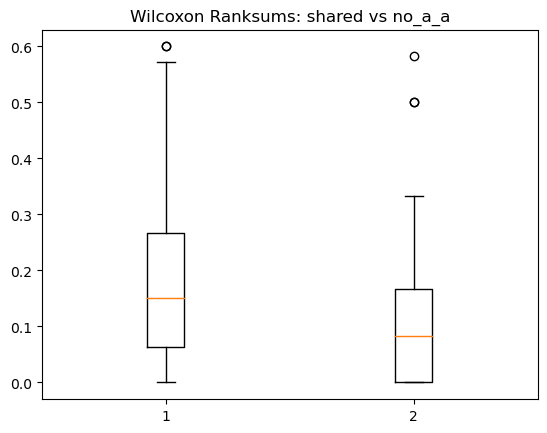

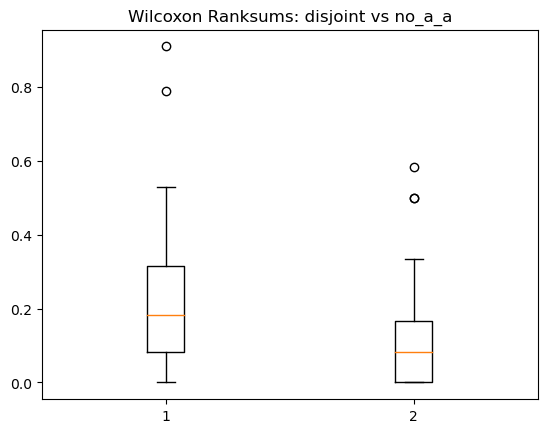

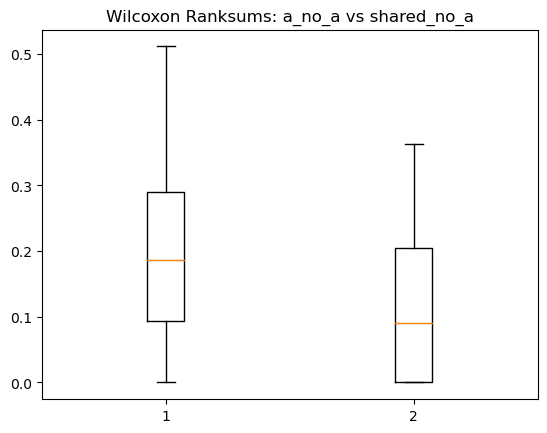

In [100]:
# Wilcoxon Excitatory - Connection Probability

# Outbound Summed PSDs

print('\n\nWilcoxon Signed Ranksums for Excitatory CHAINS Connection Probability (INBOUND)')
for c1 in C:
    for c2 in C:
        if c1.__name__ != c2.__name__:
            print(f'\n{c1.__name__} vs {c2.__name__}')
             # Find common cells for matched pairs analysis
            common_cells = set(B_chain_in_excitatory[c1.__name__].keys()) & set(B_chain_in_excitatory[c2.__name__].keys())
            B_chain_in_excitatory_matched = [B_chain_in_excitatory[c1.__name__][cell] for cell in common_cells]
            B_chain_in_excitatory_matched2 = [B_chain_in_excitatory[c2.__name__][cell] for cell in common_cells]
            
            result = stats.wilcoxon((B_chain_in_excitatory_matched), (B_chain_in_excitatory_matched2), alternative='greater')

            print('Greater:')
            print(result)
            if result.pvalue < 0.05:
                plt.figure()
                plt.boxplot([list(B_chain_in_excitatory_matched), list(B_chain_in_excitatory_matched2)])
                plt.title(f'Wilcoxon Ranksums: {c1.__name__} vs {c2.__name__}')

In [ ]:
##sIGNED RANK EXCITATORY INBOUND for conn probability- NOT MATCHING
##------------------  Test Statistic: 311.0 p-value: 0.8648658357253579

**Un-signed ranksums for chains based on probability of connections**



Wilcoxin Ranksums(Un-signed) for Excitatory CHAINS Connection Probability (INBOUND)

shared vs disjoint
Greater:
RanksumsResult(statistic=-0.653247662139831, pvalue=0.7432016861274695)

shared vs shared_no_a
Greater:
RanksumsResult(statistic=1.4132950472903998, pvalue=0.0787844948172241)

shared vs no_a_a
Greater:
RanksumsResult(statistic=1.7315537345761274, pvalue=0.04167652485979753)

shared vs a_no_a
Greater:
RanksumsResult(statistic=-0.4250511420422255, pvalue=0.6646003032858305)

disjoint vs shared
Greater:
RanksumsResult(statistic=0.653247662139831, pvalue=0.25679831387253055)

disjoint vs shared_no_a
Greater:
RanksumsResult(statistic=1.8850092749844518, pvalue=0.029714292804345198)

disjoint vs no_a_a
Greater:
RanksumsResult(statistic=2.3363064640415128, pvalue=0.009737637434945604)

disjoint vs a_no_a
Greater:
RanksumsResult(statistic=-0.02037847864848056, pvalue=0.5081292740818452)

shared_no_a vs shared
Greater:
RanksumsResult(statistic=-1.4132950472903998, pvalue=0.9212155

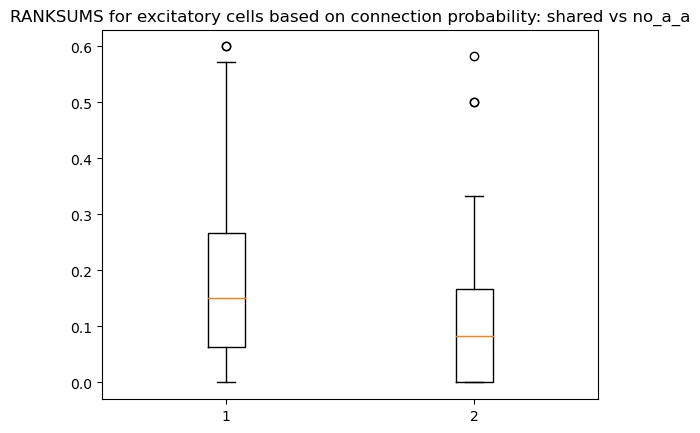

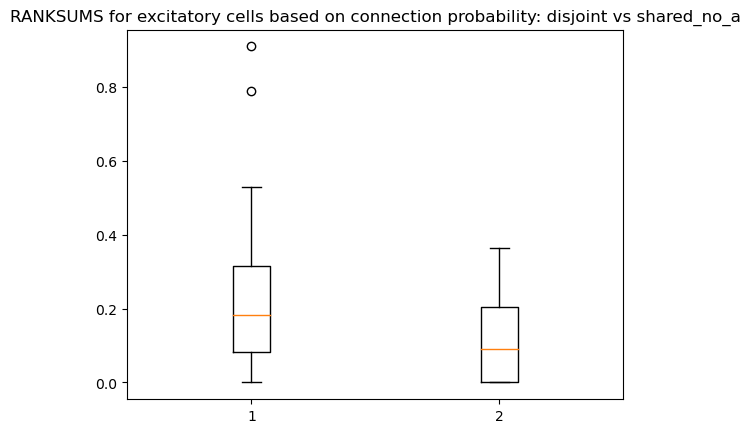

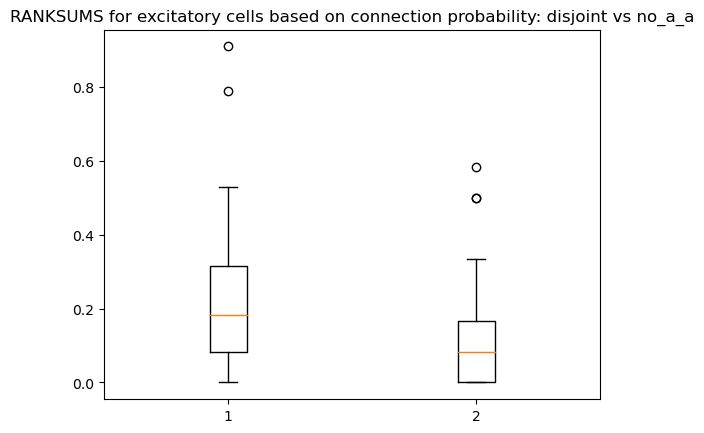

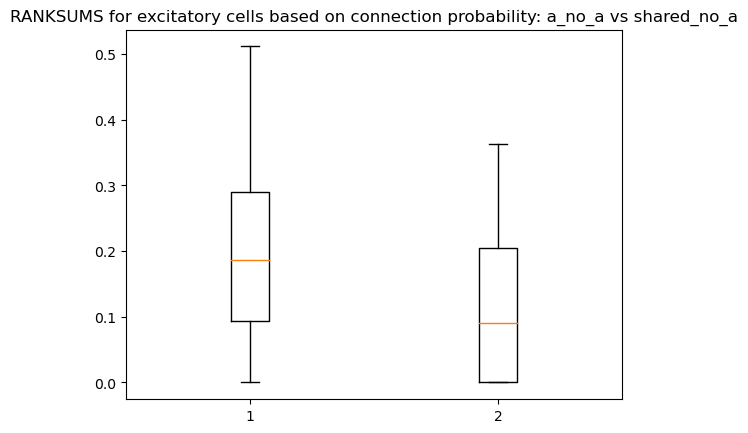

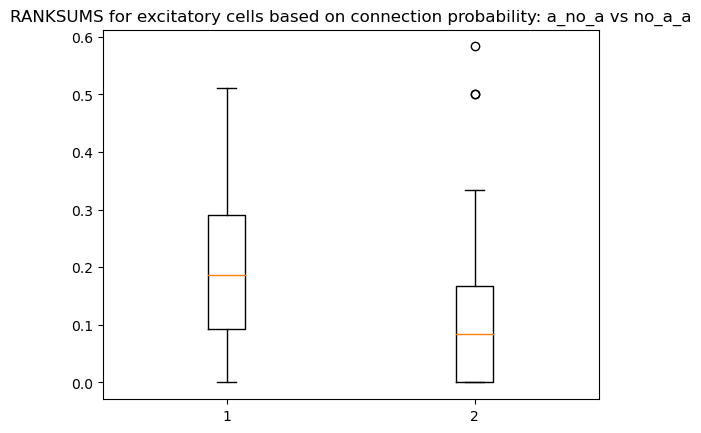

In [101]:
# Inbound Summed PSDs

print('\n\nWilcoxin Ranksums(Un-signed) for Excitatory CHAINS Connection Probability (INBOUND)')
for c1 in C:
    for c2 in C:
        if c1.__name__ != c2.__name__:
            print(f'\n{c1.__name__} vs {c2.__name__}')
            result = stats.ranksums(list(B_chain_in_excitatory[c1.__name__].values()), list(B_chain_in_excitatory[c2.__name__].values()), alternative='greater')
            print('Greater:')
            print(result)
            if result.pvalue < 0.05:
                plt.figure()
                plt.boxplot([list(B_chain_in_excitatory[c1.__name__].values()), list(B_chain_in_excitatory[c2.__name__].values())])
                plt.title(f'RANKSUMS for excitatory cells based on connection probability: {c1.__name__} vs {c2.__name__}')

In [ ]:
#-----Excitatory, Inbound - Wilcoxin unsigned for connection prob. - NOT MATCHING
### --- Test Statistic: -0.8728091689666242 p-value: 0.8086164494418926

**Un-signed ranksums for non-zero summed PSD's - by cell**

In [102]:
# Inbound Summed PSDs

print('\n\nSUMMED INBOUND PSDS for Excitatory CHAINS normalized based on middle cell')
for c1 in C:
    for c2 in C:
        if c1.__name__ != c2.__name__:
            print(f'\n{c1.__name__} vs {c2.__name__}')
            result = stats.ranksums(list(W_in_excitatory_chains[c1.__name__].values()), list(W_in_excitatory_chains[c2.__name__].values()), alternative='greater')
            print('Greater:')
            print(result)
            if result.pvalue < 0.05:
                plt.figure()
                plt.boxplot([list(W_in_excitatory_chains[c1.__name__].values()), list(W_in_excitatory_chains[c2.__name__].values())])
                plt.title(f'OUTBOUND SUMMED PSDS: {c1.__name__} vs {c2.__name__}')



SUMMED INBOUND PSDS for Excitatory CHAINS normalized based on middle cell

shared vs disjoint
Greater:
RanksumsResult(statistic=0.22780124699975274, pvalue=0.4099003786083848)

shared vs shared_no_a
Greater:
RanksumsResult(statistic=0.13179426029667, pvalue=0.4475735132850578)

shared vs no_a_a
Greater:
RanksumsResult(statistic=-0.7026506773883116, pvalue=0.7588632638507835)

shared vs a_no_a
Greater:
RanksumsResult(statistic=-0.6150602574013412, pvalue=0.7307425365260825)

disjoint vs shared
Greater:
RanksumsResult(statistic=-0.22780124699975274, pvalue=0.5900996213916152)

disjoint vs shared_no_a
Greater:
RanksumsResult(statistic=-0.048131095111188946, pvalue=0.5191941176996614)

disjoint vs no_a_a
Greater:
RanksumsResult(statistic=-0.768723798599197, pvalue=0.7789713530789929)

disjoint vs a_no_a
Greater:
RanksumsResult(statistic=-0.4783326101625762, pvalue=0.683793255143006)

shared_no_a vs shared
Greater:
RanksumsResult(statistic=-0.13179426029667, pvalue=0.5524264867149422)

sh